In [1]:
# =====================================================
# Traffic  PREDICTION - ENCODING (Fase 1)
# =====================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from math import pi
from dslabs_functions import encode_cyclic_variables


# ------------------ CARREGAR DADOS ------------------
data = pd.read_csv("/content/TrafficTwoMonth.csv")

print(f"Dataset carregado: {data.shape}")
print(f"Dataset carregado: {data.head()}")


# 2. CYCLIC VARIABLES

import pandas as pd

def prepare_and_encode(data: pd.DataFrame, vars: dict):
    original_len = len(data)

    fake_row = {v: vmax for v, vmax in vars.items()}
    data = pd.concat([data, pd.DataFrame([fake_row])], ignore_index=True)

    encode_cyclic_variables(data, list(vars.keys()))
    data = data.iloc[:original_len]
    return data

day_of_week = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
data['Day of the week'] = data['Day of the week'].map(day_of_week)
trafic_situation = { 'low': 0 , 'normal':1 , 'high':2, 'heavy' :3}
data['Traffic Situation'] = data['Traffic Situation'].map(trafic_situation)
data = prepare_and_encode(data,{"Day of the week": 7,"Traffic Situation": 4} )

data.to_csv("traffic_encoding.csv", index=False)
print("Criado ficheiro csv")

Dataset carregado: (5952, 9)
Dataset carregado:           Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10         Tuesday        13          2         2   
1  12:15:00 AM    10         Tuesday        14          1         1   
2  12:30:00 AM    10         Tuesday        10          2         2   
3  12:45:00 AM    10         Tuesday        10          2         2   
4   1:00:00 AM    10         Tuesday        11          2         1   

   TruckCount  Total Traffic Situation  
0          24     41            normal  
1          36     52            normal  
2          32     46            normal  
3          36     50            normal  
4          34     48            normal  
Criado ficheiro csv


In [ ]:
# =====================================================
# FLIGHT STATUS PREDICTION — Data SPLIT
# =====================================================
from pandas import read_csv, DataFrame, concat
from sklearn.model_selection import train_test_split
from dslabs_functions import dataframe_temporal_train_test_split
import matplotlib.pyplot as plt
from numpy import array, ndarray
import pandas as pd

train , test = dataframe_temporal_train_test_split(data, 0.7)

In [2]:
from pandas import Series
from sklearn.base import RegressorMixin


class PersistenceOptimistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last: float = 0.0
        return

    def fit(self, X: Series):
        self.last = X.iloc[-1]
        # print(self.last)
        return

    def predict(self, X: Series):
        prd: list = X.shift().values.ravel()
        prd[0] = self.last
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

In [3]:
from dslabs_functions import plot_forecasting_eval,plot_forecasting_series, series_train_test_split
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from numpy import array, ndarray, arange, set_printoptions, log, std
from  pandas import DataFrame, Series


def linear_regression_Persistence_evaluation(filename: str, file_tag: str, index_col: str, target: str, title: str, num:float = 0.9):
    data: DataFrame = read_csv(filename, index_col=index_col, parse_dates=True, infer_datetime_format=True)

    series: Series = data[target]
    train, test = series_train_test_split(data, num)

    trnX = arange(len(train)).reshape(-1, 1)
    trnY = train.to_numpy()
    tstX = arange(len(train), len(data)).reshape(-1, 1)
    tstY = test.to_numpy()

    model = LinearRegression()
    model.fit(trnX, trnY)

    prd_trn: Series = Series(model.predict(trnX).reshape(-1), index=train.index)
    prd_tst: Series = Series(model.predict(tstX).reshape(-1), index=test.index)

    plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression Evaluation - {title}")
    plt.tight_layout()
    plt.savefig(f"{file_tag}_linear_regression_evaluation_{title}_time.png")
    plt.show()
    plt.clf()

    plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - Linear Regression Forecast - {title}",
        xlabel=index_col,
        ylabel=target,
    )
    plt.tight_layout()
    plt.savefig(f"{file_tag}_linear_regression_forecast_{title}_time.png")
    plt.show()
    plt.clf()

    # Persistence
    fr_mod = PersistenceOptimistRegressor()


    # Treinar persistência
    fr_mod = PersistenceOptimistRegressor()
    fr_mod.fit(train)

    # Previsões
    prd_trn = fr_mod.predict(train)
    prd_tst = fr_mod.predict(test)

    plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Persistence Optimist - {title}")
    savefig(f"{file_tag}_persistence_optim_eval_{title}_time.png")

    plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Persistence Optimist - {title}",
    xlabel= index_col,
    ylabel=target,
    )
    savefig(f"{file_tag}_persistence_optim_forecast__{title}_time.png")

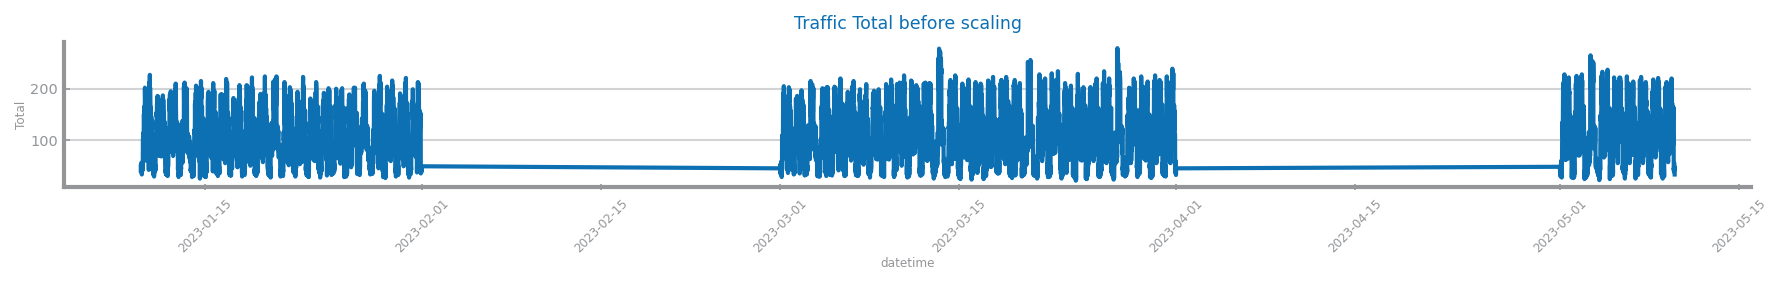

<Figure size 600x450 with 0 Axes>

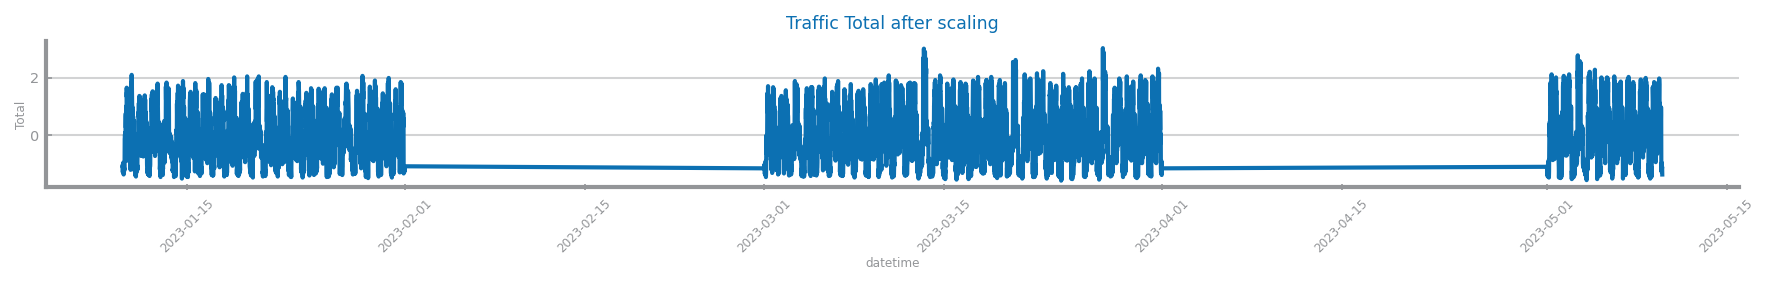

<Figure size 600x450 with 0 Axes>

In [4]:
# =====================================================
# FLIGHT STATUS PREDICTION — Data SCALE
# =====================================================

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame, Series,to_datetime
from dslabs_functions import plot_line_chart, HEIGHT

def scale_all_dataframe(data: DataFrame) -> DataFrame:
    vars: list[str] = data.columns.to_list()
    transf: StandardScaler = StandardScaler().fit(data)
    df = DataFrame(transf.transform(data), index=data.index)
    df.columns = vars
    return df

file_tag: str = "Traffic"
index_col: str = "Time"
target: int = "Total"
traffic_data: DataFrame = read_csv("/content/traffic_encoding.csv")

traffic_data["day"] = traffic_data["Date"].astype(int)

reset = (traffic_data["day"].diff().fillna(0) < 0).astype(int)
counter = reset.cumsum()
traffic_data["month"] = 1 + counter * 2

traffic_data["year"] = 2023
traffic_data["datetime"] = to_datetime(
    traffic_data["year"].astype(str) + "-" +
    traffic_data["month"].astype(str) + "-" +
    traffic_data["day"].astype(str) + " " +
    traffic_data["Time"]
)


traffic_data = traffic_data.set_index("datetime")
traffic_data = traffic_data.drop(columns=["Date", "Time", "day", "month", "year"])
series: Series = traffic_data[target]

# Before scaling

plt.figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} {target} before scaling",
)
plt.tight_layout()
plt.savefig(f"{file_tag}_before_scaling_time.png")
plt.show()
plt.clf()

# After scaling

df: DataFrame = scale_all_dataframe(traffic_data)

ss: Series = df[target]
plt.figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    ss.index.to_list(),
    ss.to_list(),
    xlabel=ss.index.name,
    ylabel=target,
    title=f"{file_tag} {target} after scaling",
)
plt.tight_layout()
plt.savefig(f"{file_tag}_after_scaling_time.png")
plt.show()
plt.clf()

# Save scaled data
df.to_csv(f"traffic_scaled_time.csv")

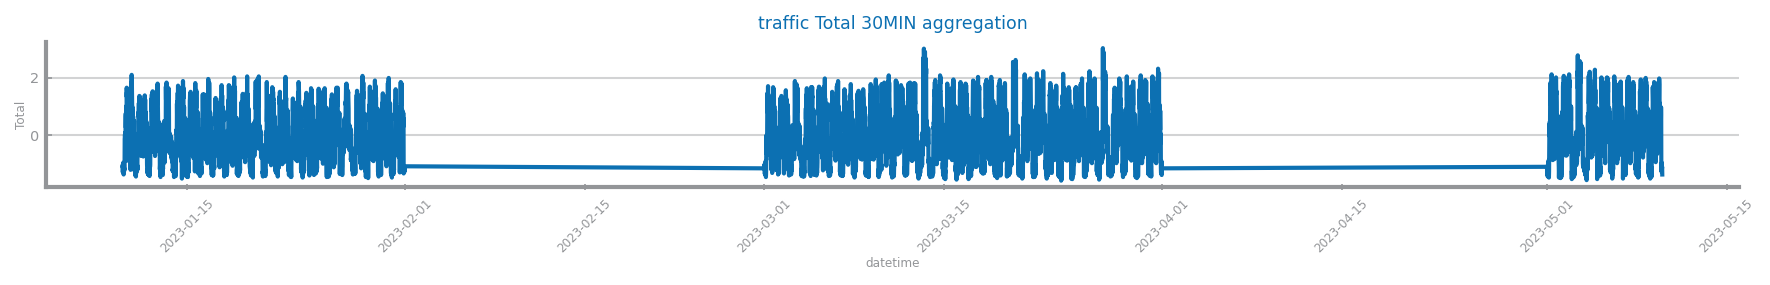

<Figure size 600x450 with 0 Axes>

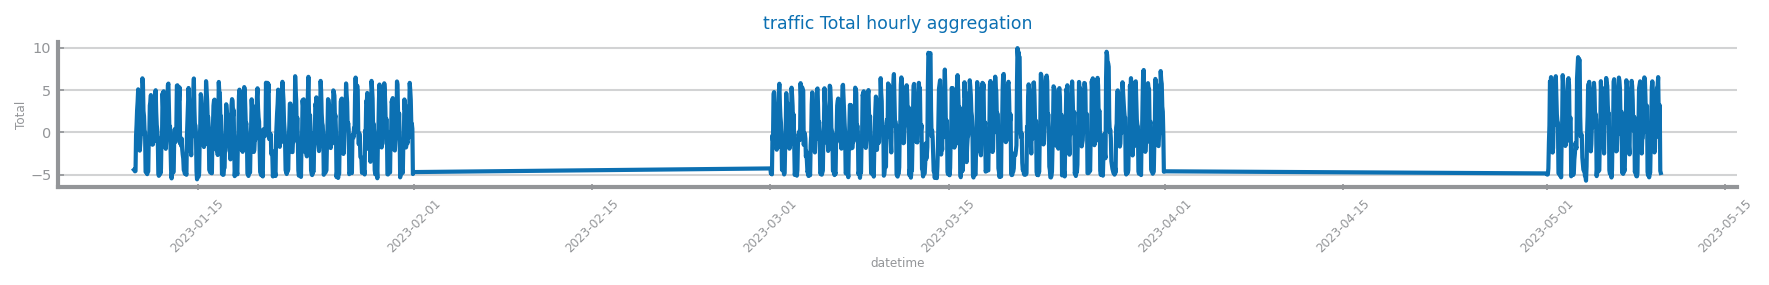

<Figure size 600x450 with 0 Axes>

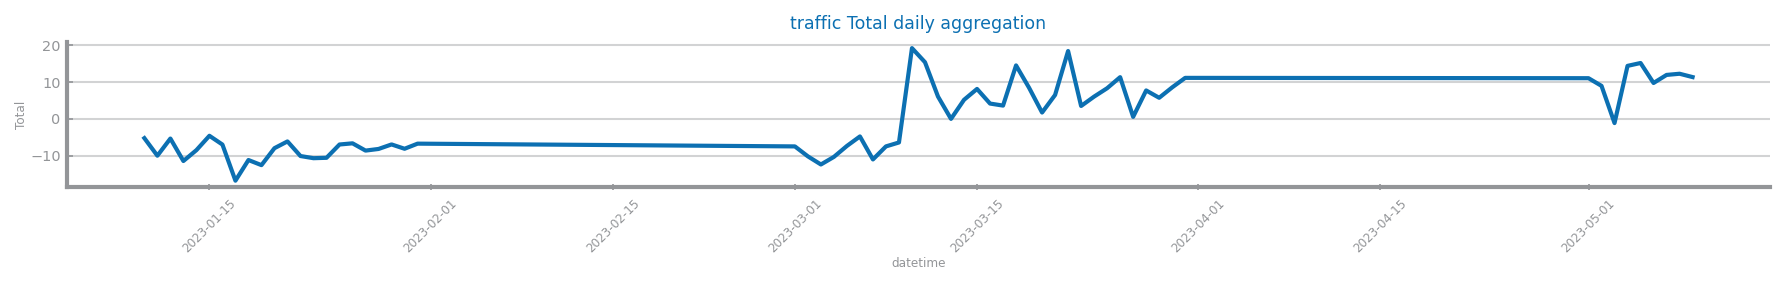

<Figure size 600x450 with 0 Axes>

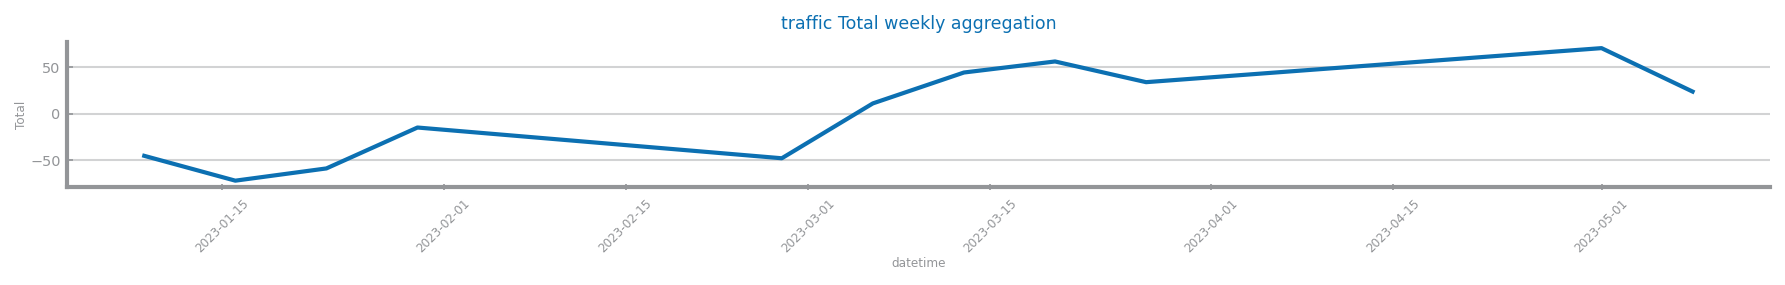

<Figure size 600x450 with 0 Axes>

In [6]:
# =====================================================
# TRAFFIC STATUS PREDICTION — Time Series (Aggregation)
# =====================================================

import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame, Series
from dslabs_functions import ts_aggregation_by, HEIGHT, plot_line_chart

filename: str = "traffic_scaled_time.csv"
file_tag: str = "traffic"
index_col: str = "datetime"
target: str = "Total"
traffic_data: DataFrame = read_csv(filename, index_col=index_col, parse_dates=True, infer_datetime_format=True)
series: Series = traffic_data[target]

grans: dict = { "30MIN" : "30min","hourly": "H", "daily": "D", "weekly": "W"}

for gran, freq in grans.items():
    traffic_data_gran: DataFrame = ts_aggregation_by(series, gran_level=freq, agg_func="sum")
    plt.figure(figsize=(3 * HEIGHT, HEIGHT / 2))
    plot_line_chart(
        traffic_data_gran.index.to_list(),
        traffic_data_gran.to_list(),
        xlabel=traffic_data_gran.index.name,
        ylabel=target,
        title=f"{file_tag} {target} {gran} aggregation",
    )
    plt.tight_layout()
    plt.savefig(f"{file_tag}_{gran}_aggregation_time.png")
    plt.show()
    plt.clf()

    # Save aggregated data
    traffic_data_gran.to_csv(f"traffic_{gran}_aggregated_time.csv")

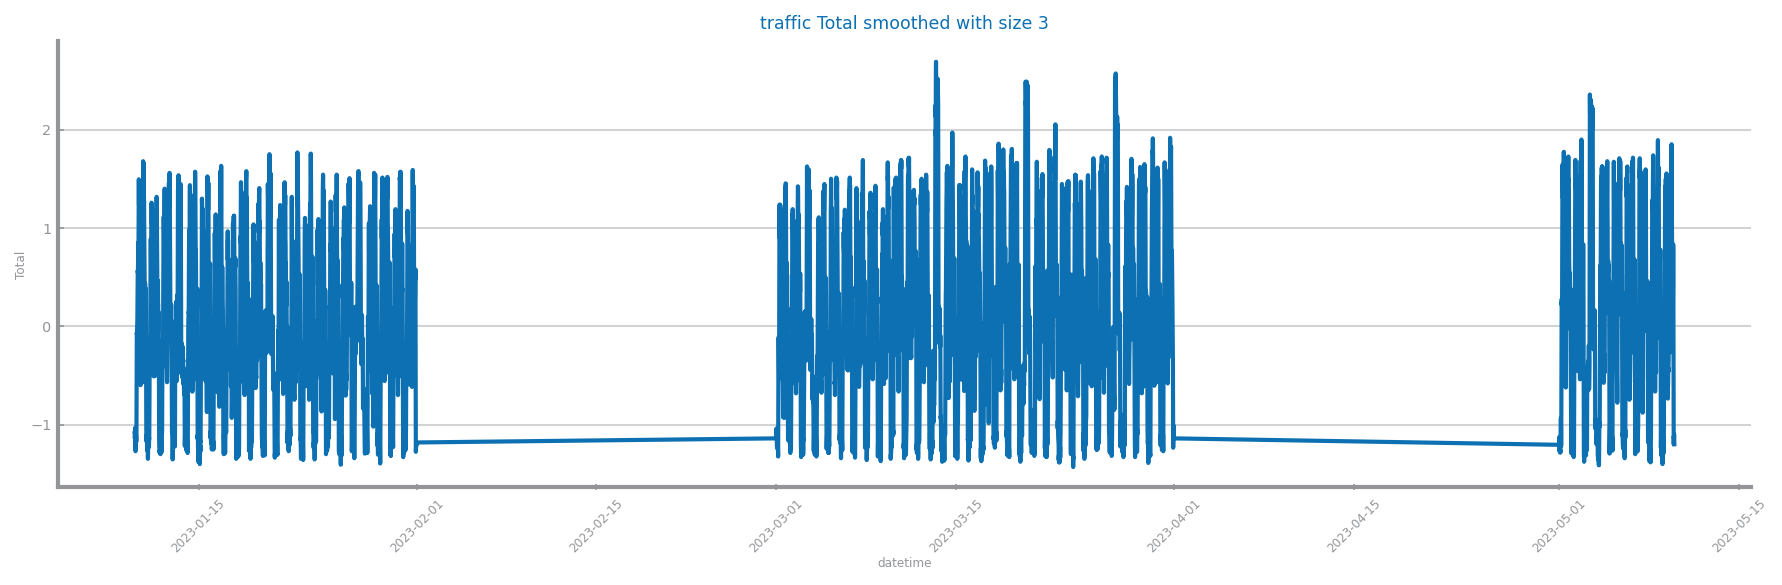

<Figure size 600x450 with 0 Axes>

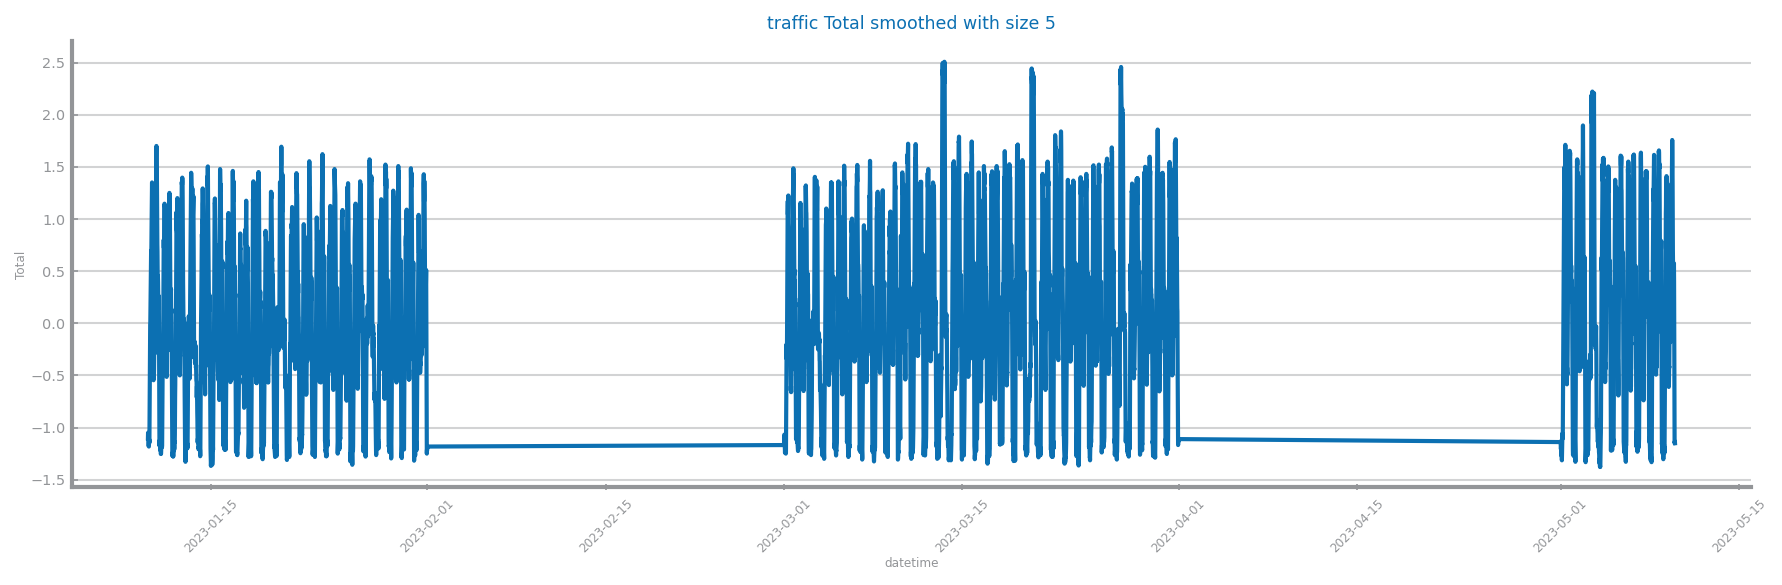

<Figure size 600x450 with 0 Axes>

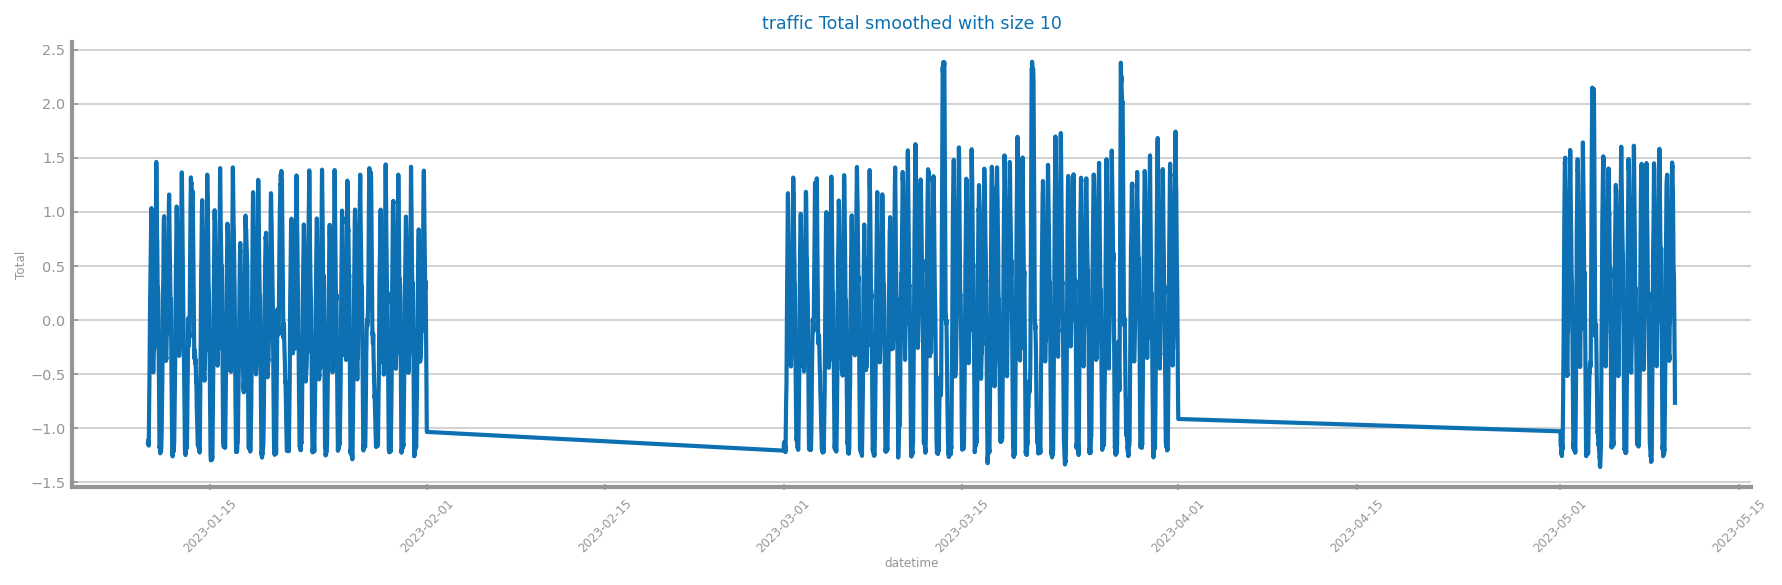

<Figure size 600x450 with 0 Axes>

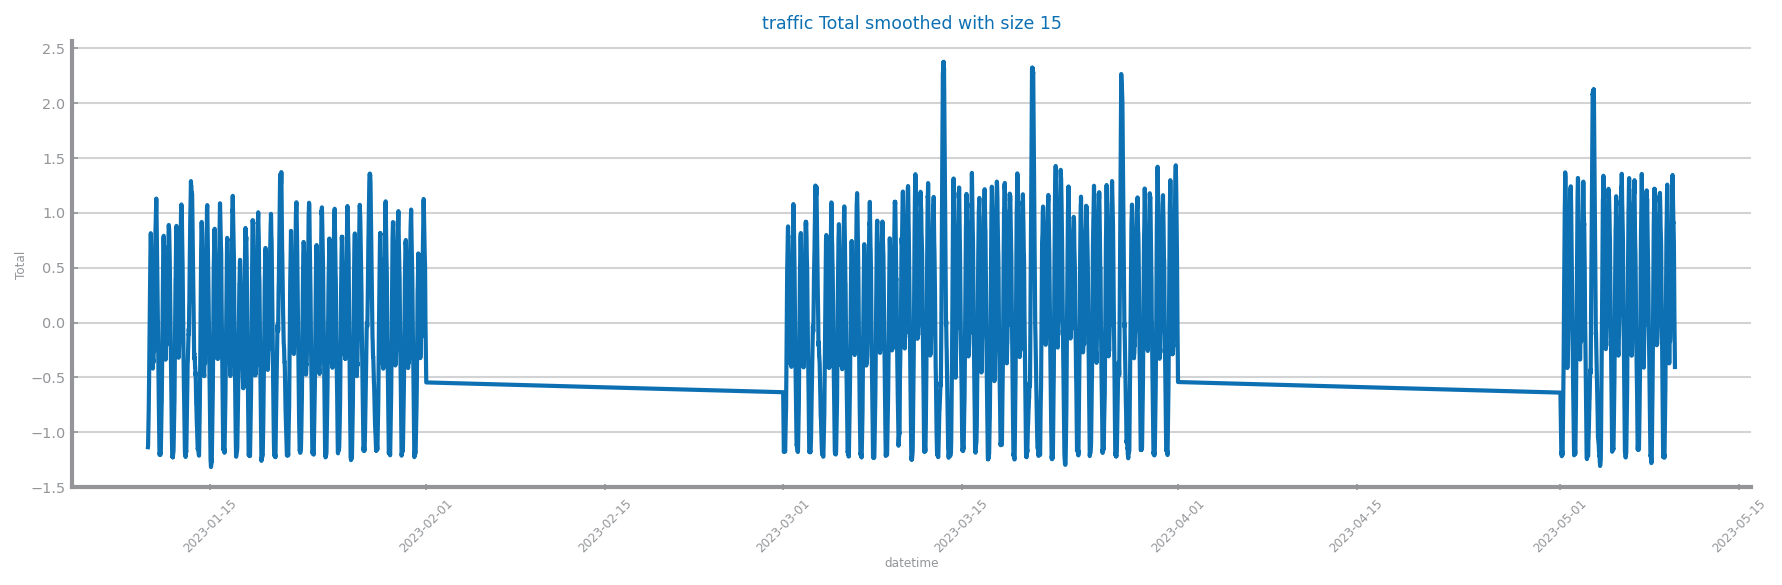

<Figure size 600x450 with 0 Axes>

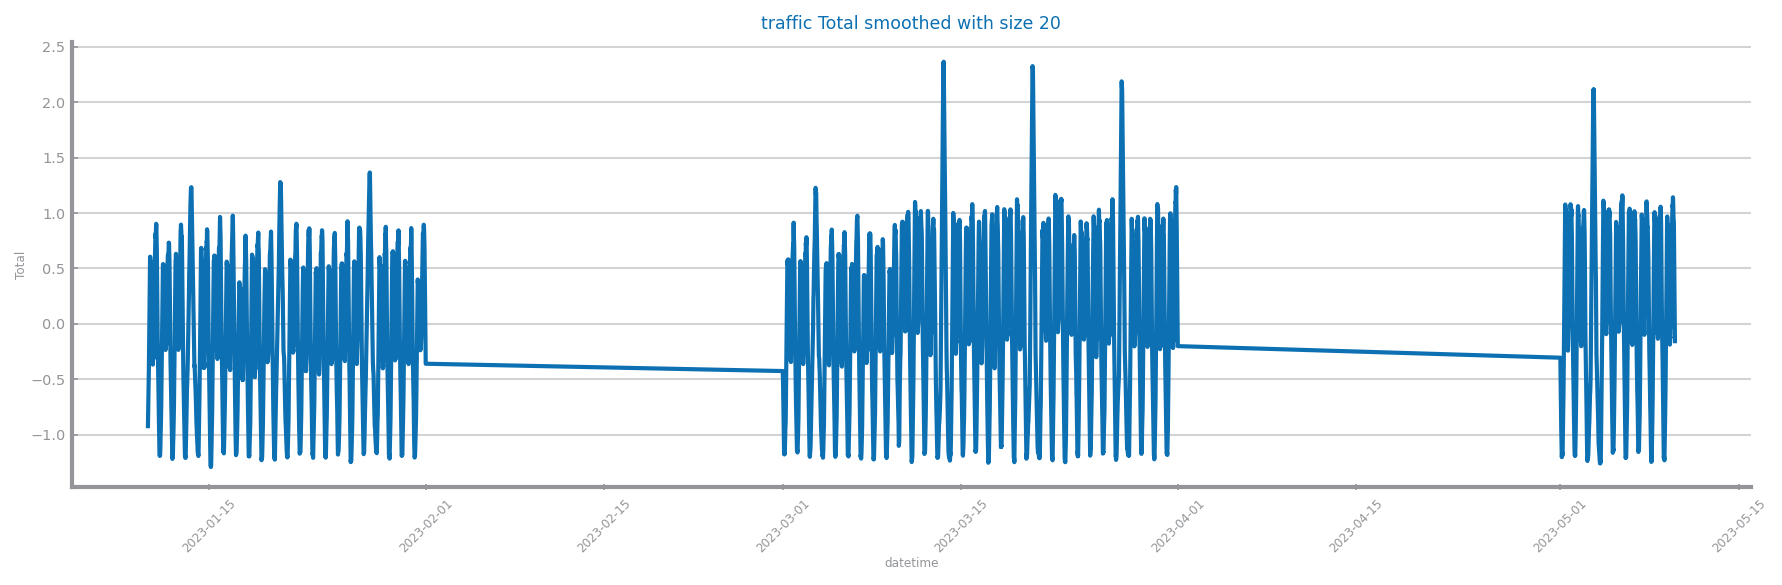

<Figure size 600x450 with 0 Axes>

In [11]:
# =====================================================
# TRAFFIC STATUS PREDICTION — Time Series (Smoothing)
# =====================================================

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from pandas import DataFrame, read_csv, Series
from dslabs_functions import plot_line_chart, HEIGHT

filename: str = "traffic_30MIN_aggregated_time.csv"
file_tag: str = "traffic"
index_col: str = "datetime"
target: str = "Total"
traffic_data: DataFrame = read_csv(filename, index_col=index_col, parse_dates=True, infer_datetime_format=True)

series: Series = traffic_data[target]

sizes: list[int] = [3, 5, 10, 15, 20]

for i in range(len(sizes)):
    fig = plt.figure(figsize=(3 * HEIGHT, HEIGHT))
    ss_smooth: Series = series.rolling(window=sizes[i]).mean().dropna()
    plot_line_chart(
        ss_smooth.index.to_list(),
        ss_smooth.to_list(),
        xlabel=ss_smooth.index.name,
        ylabel=target,
        title=f"{file_tag} {target} smoothed with size {sizes[i]}",
    )
    plt.tight_layout()
    plt.savefig(f"{file_tag}_smoothed_size_{sizes[i]}_time.png")
    plt.show()
    plt.clf()

    # Save smoothed data
    ss_smooth.to_csv(f"{file_tag}_smoothed_size_{sizes[i]}_time.csv")

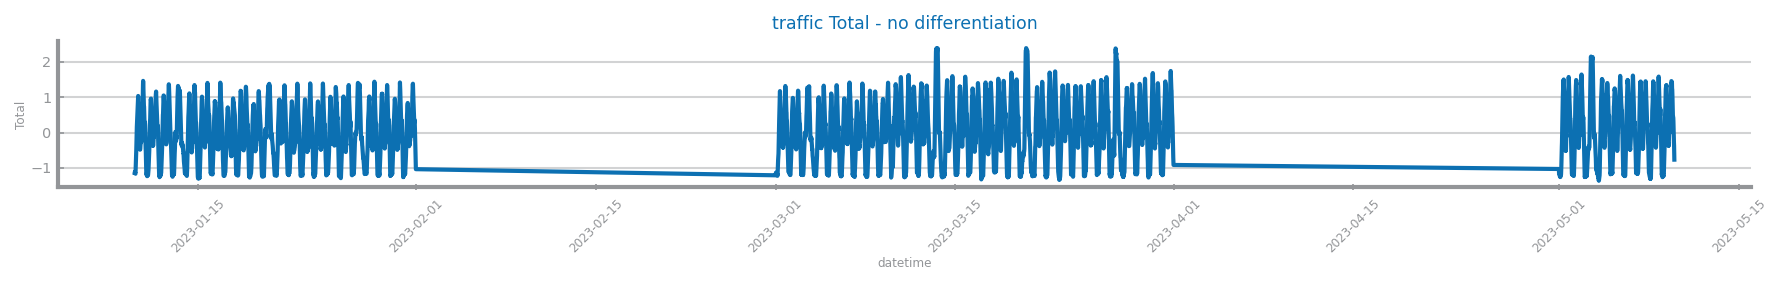

<Figure size 600x450 with 0 Axes>

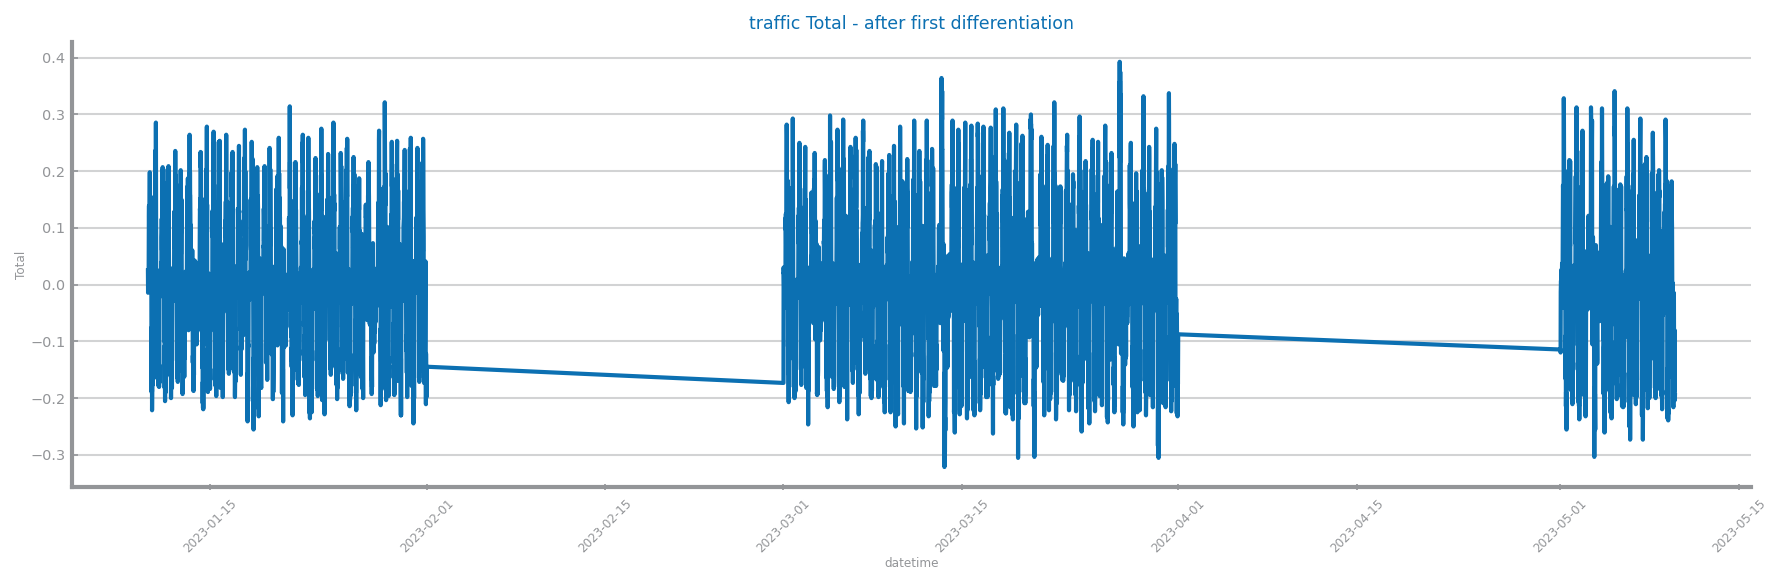

<Figure size 600x450 with 0 Axes>

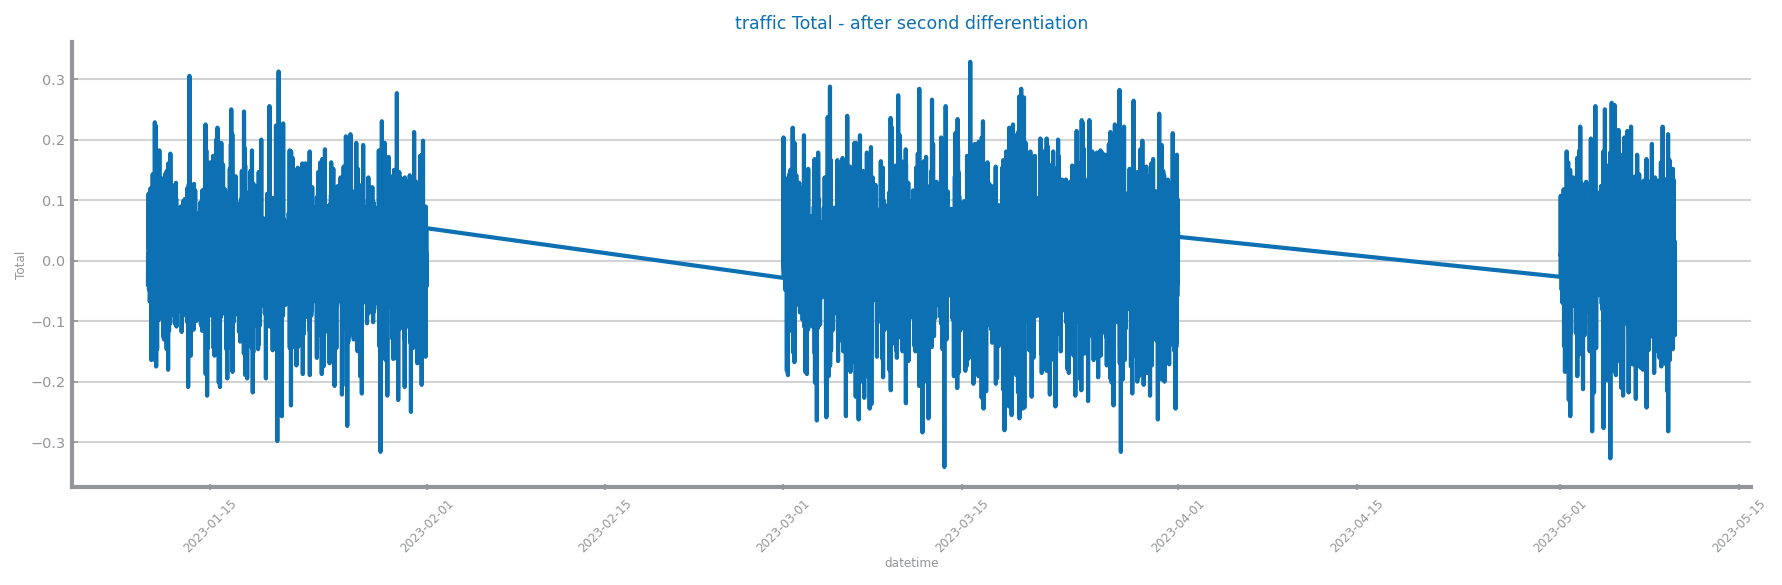

<Figure size 600x450 with 0 Axes>

In [13]:

# =====================================================
# TRAFFIC STATUS PREDICTION — Time Series (Differentiation)
# =====================================================

import matplotlib.pyplot as plt
from pandas import DataFrame, read_csv, Series

from dslabs_functions import HEIGHT, plot_line_chart

filename: str = "traffic_smoothed_size_10_time.csv"
file_tag: str = "traffic"
index_col: str = "datetime"
target: str = "Total"
traffic_data: DataFrame = read_csv(filename, index_col=index_col, parse_dates=True, infer_datetime_format=True)
series: Series = traffic_data[target]

# ----------------------------
# No differentiation
# ----------------------------

plt.figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} {target} - no differentiation",
)
plt.tight_layout()
plt.savefig(f"{file_tag}_no_diff_time.png")
plt.show()
plt.clf()

# ----------------------------
# First differentiation
# ----------------------------

ss_diff: Series = series.diff().dropna()

plt.figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_diff.index.to_list(),
    ss_diff.to_list(),
    title=f"{file_tag} {target} - after first differentiation",
    xlabel=series.index.name,
    ylabel=target,
)
plt.tight_layout()
plt.savefig(f"{file_tag}_first_diff_time.png")
plt.show()
plt.clf()

ss_diff.to_csv(f"traffic_first_diff_time.csv")

# ----------------------------
# Second differentiation
# ----------------------------
ss_diff: Series = ss_diff.diff().dropna()

plt.figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_diff.index.to_list(),
    ss_diff.to_list(),
    title=f"{file_tag} {target} - after second differentiation",
    xlabel=series.index.name,
    ylabel=target,
)
plt.tight_layout()
plt.savefig(f"{file_tag}_second_diff_time.png")
plt.show()
plt.clf()

ss_diff.to_csv(f"traffic_second_diff_time.csv")

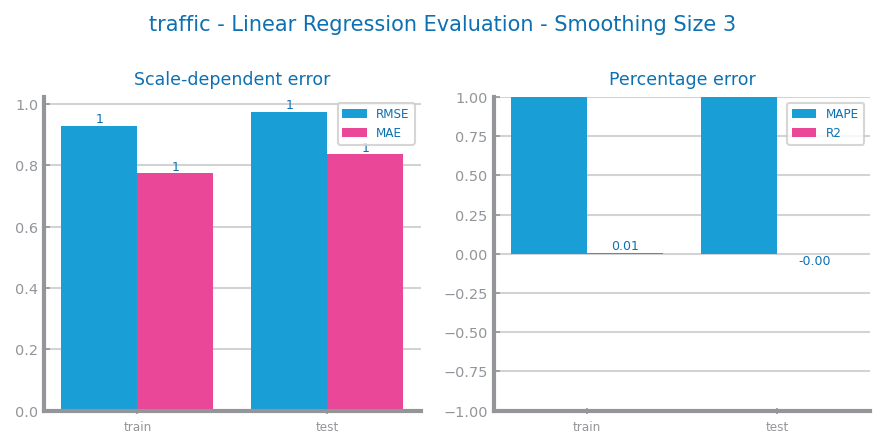

<Figure size 600x450 with 0 Axes>

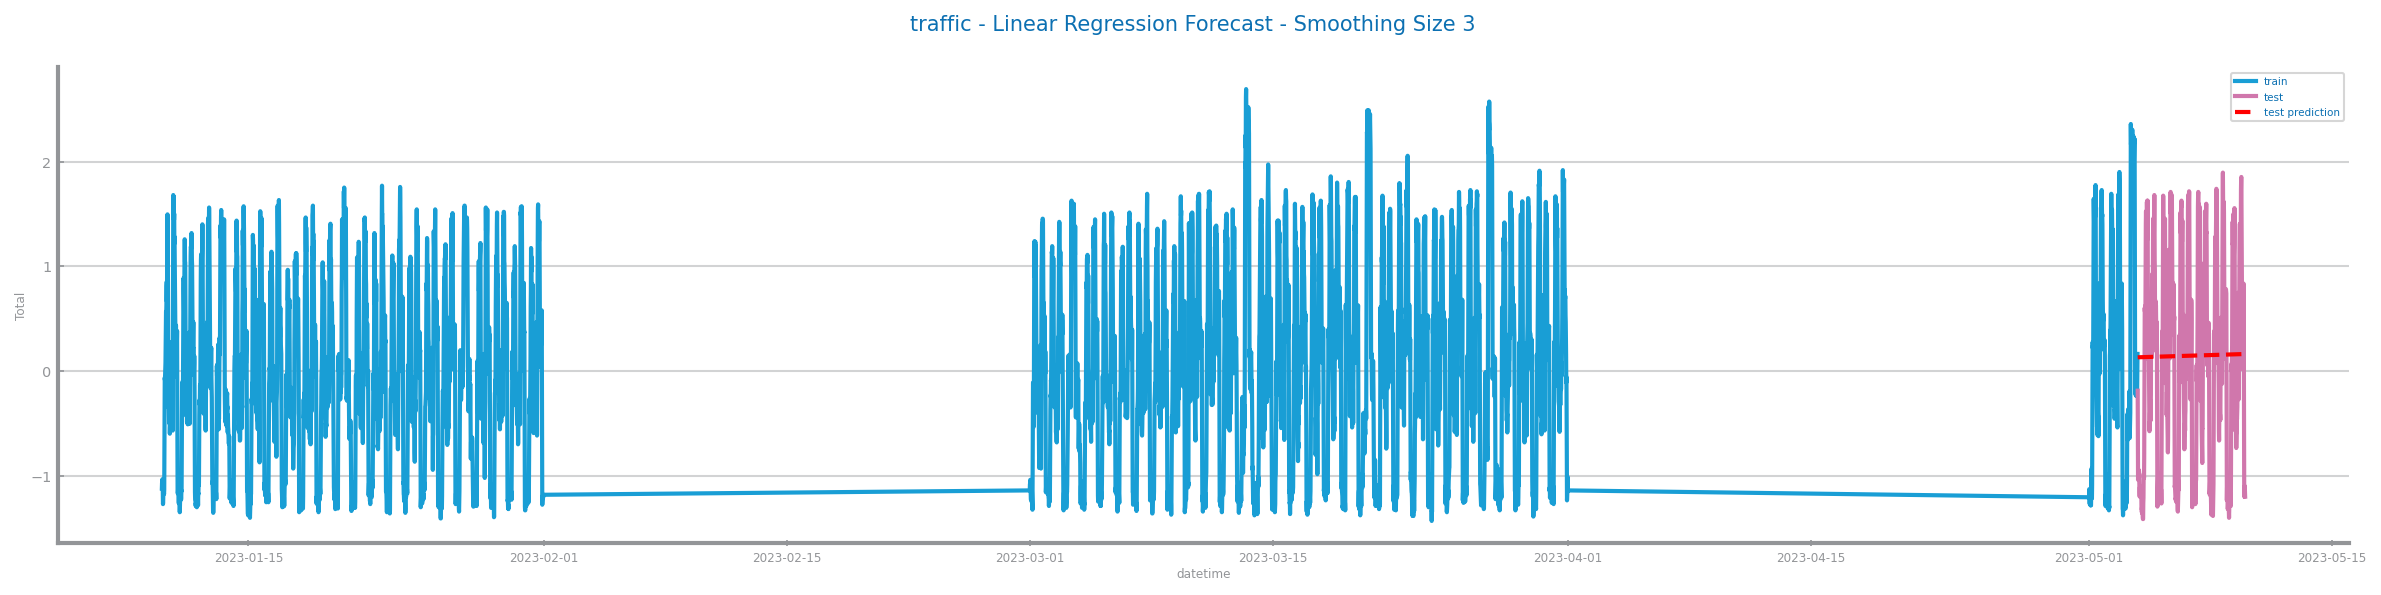

<Figure size 600x450 with 0 Axes>

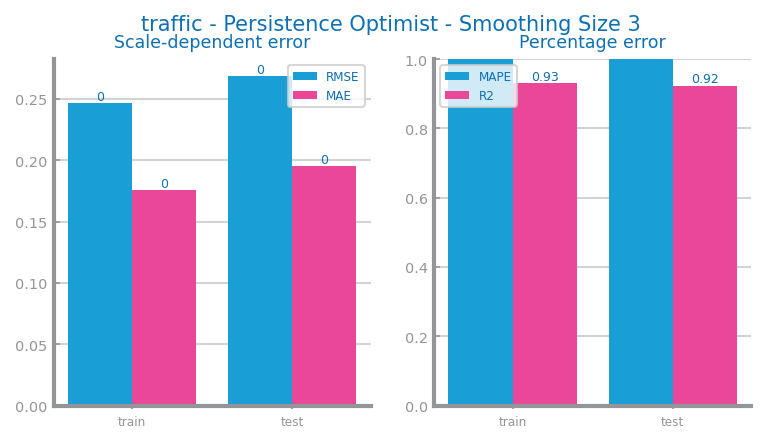

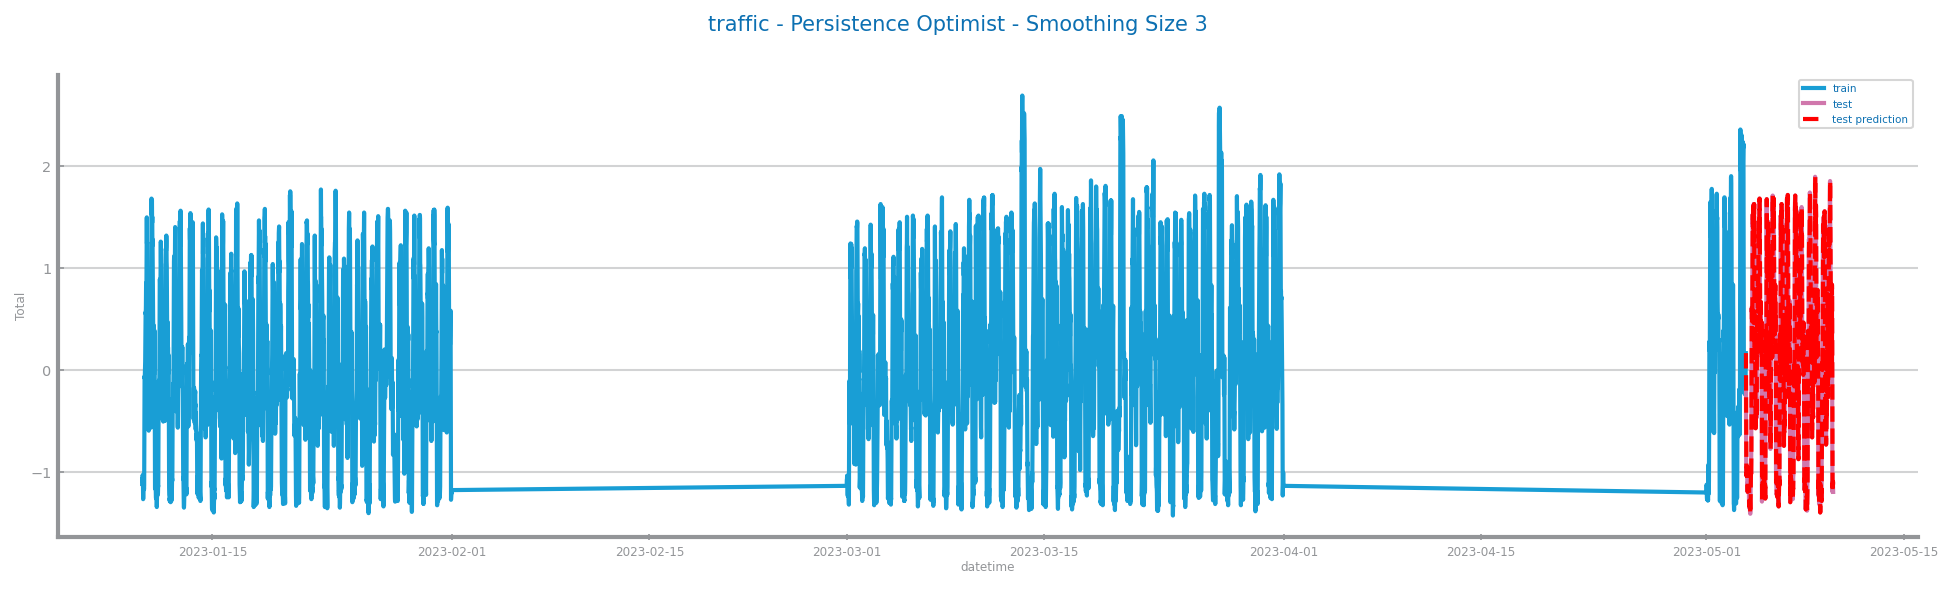

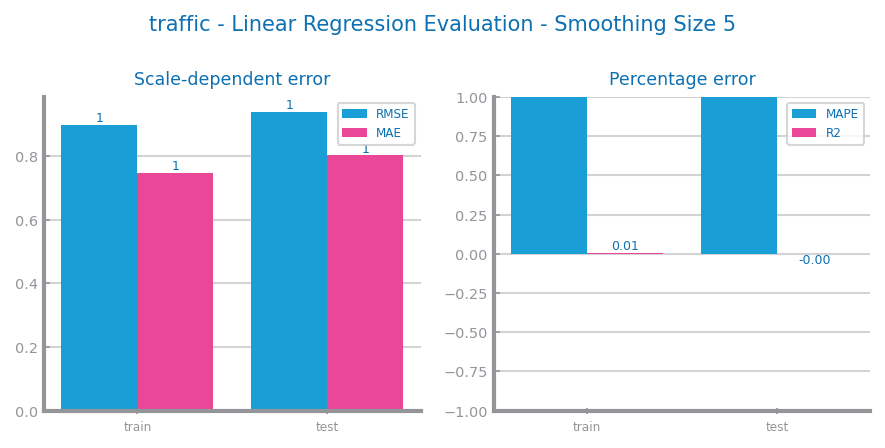

<Figure size 600x450 with 0 Axes>

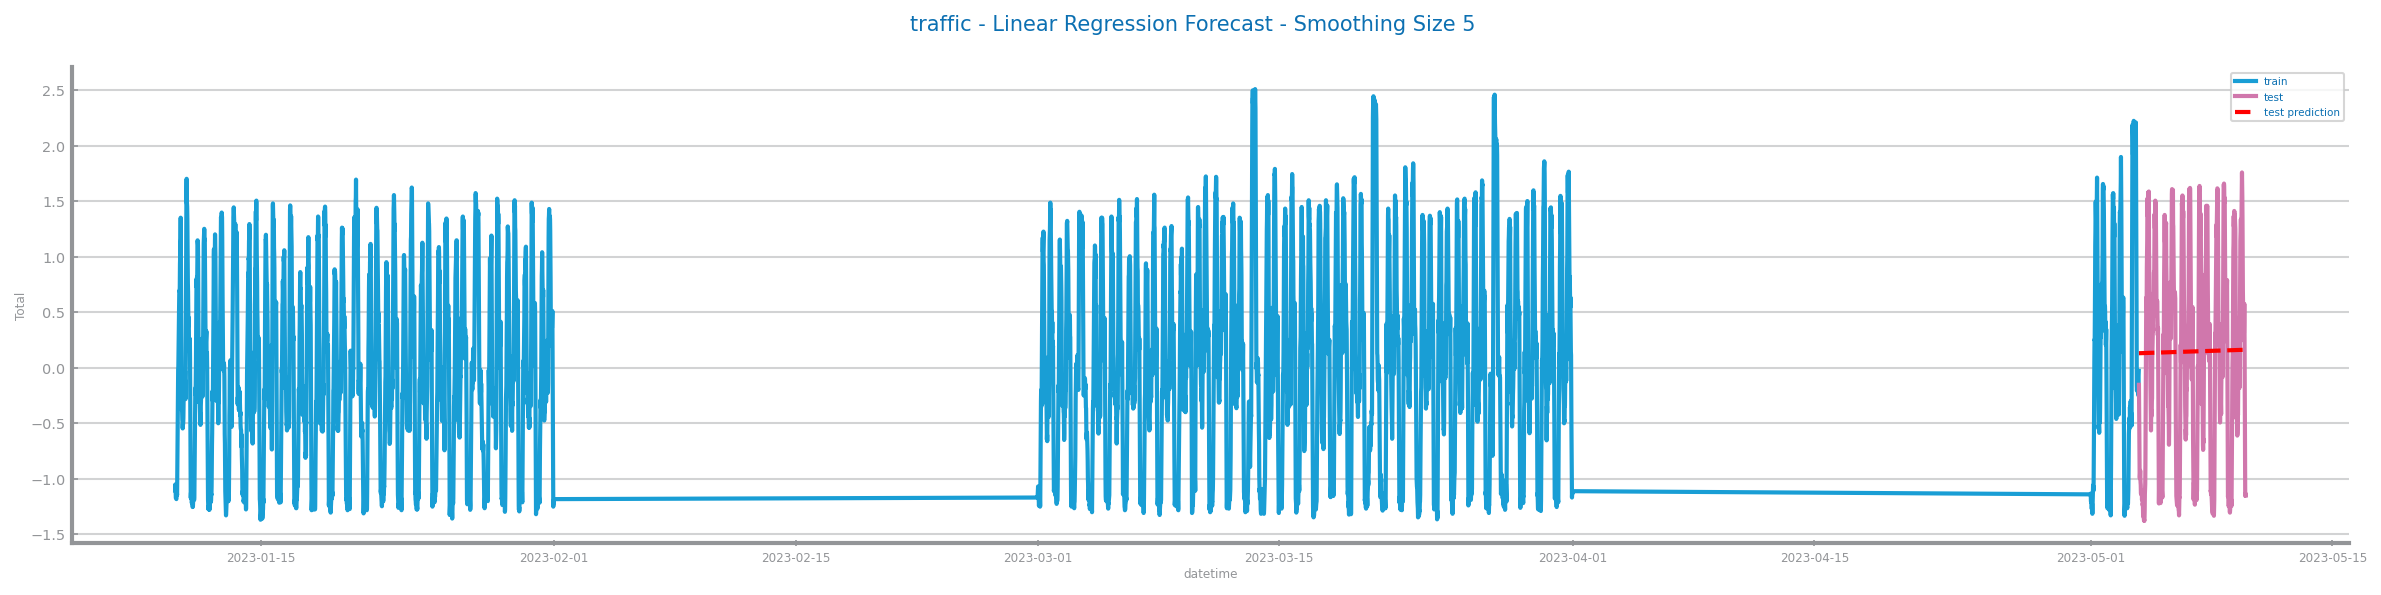

<Figure size 600x450 with 0 Axes>

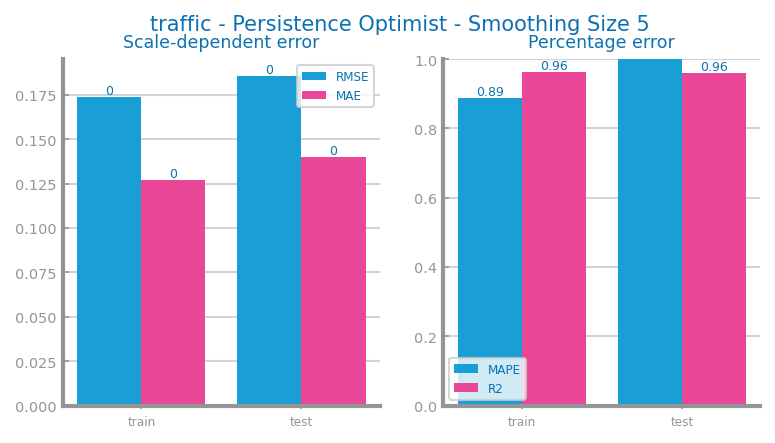

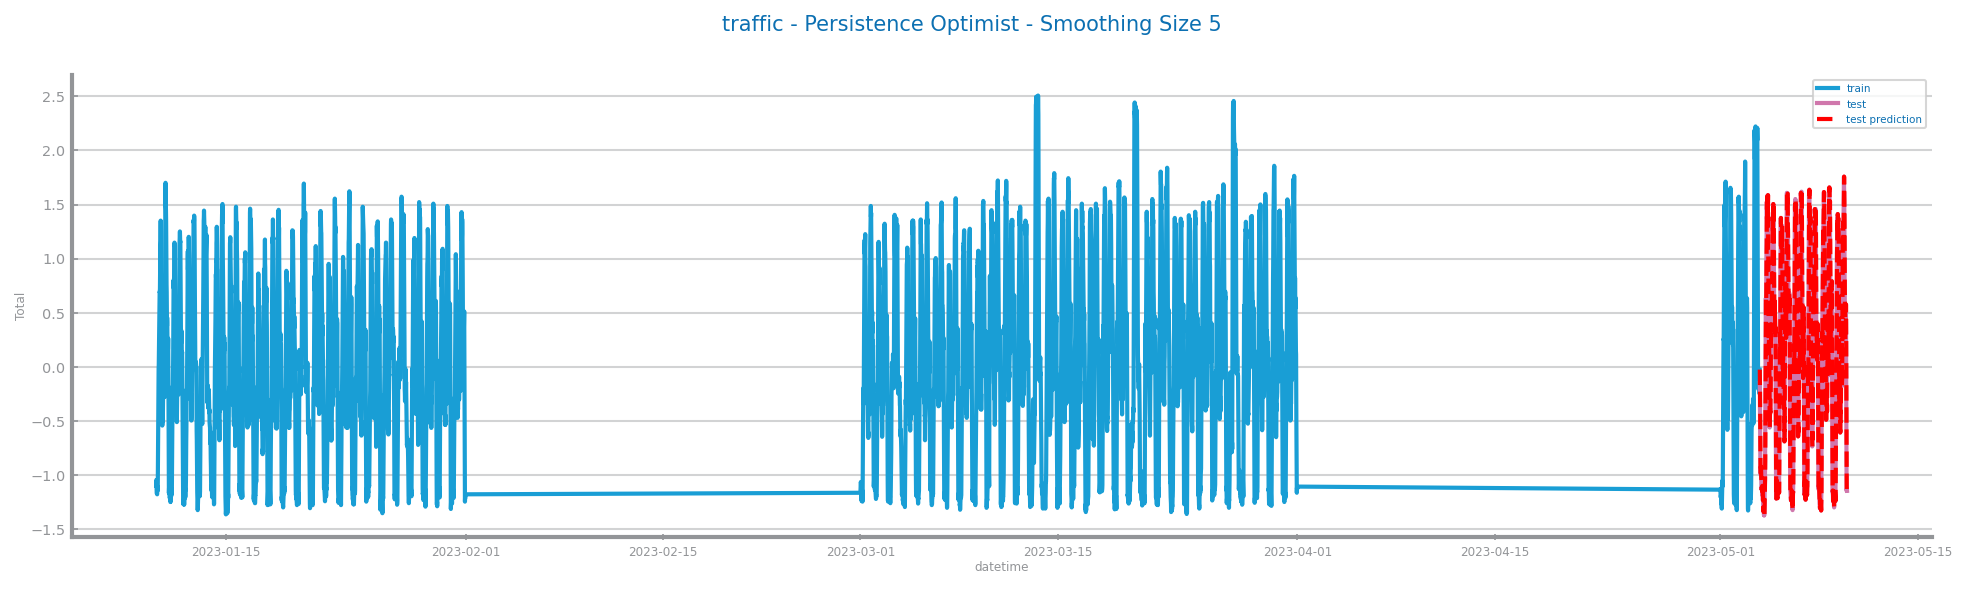

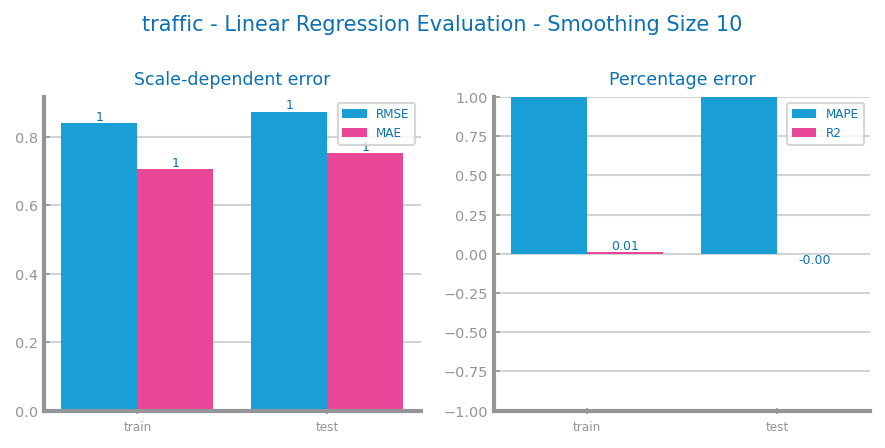

<Figure size 600x450 with 0 Axes>

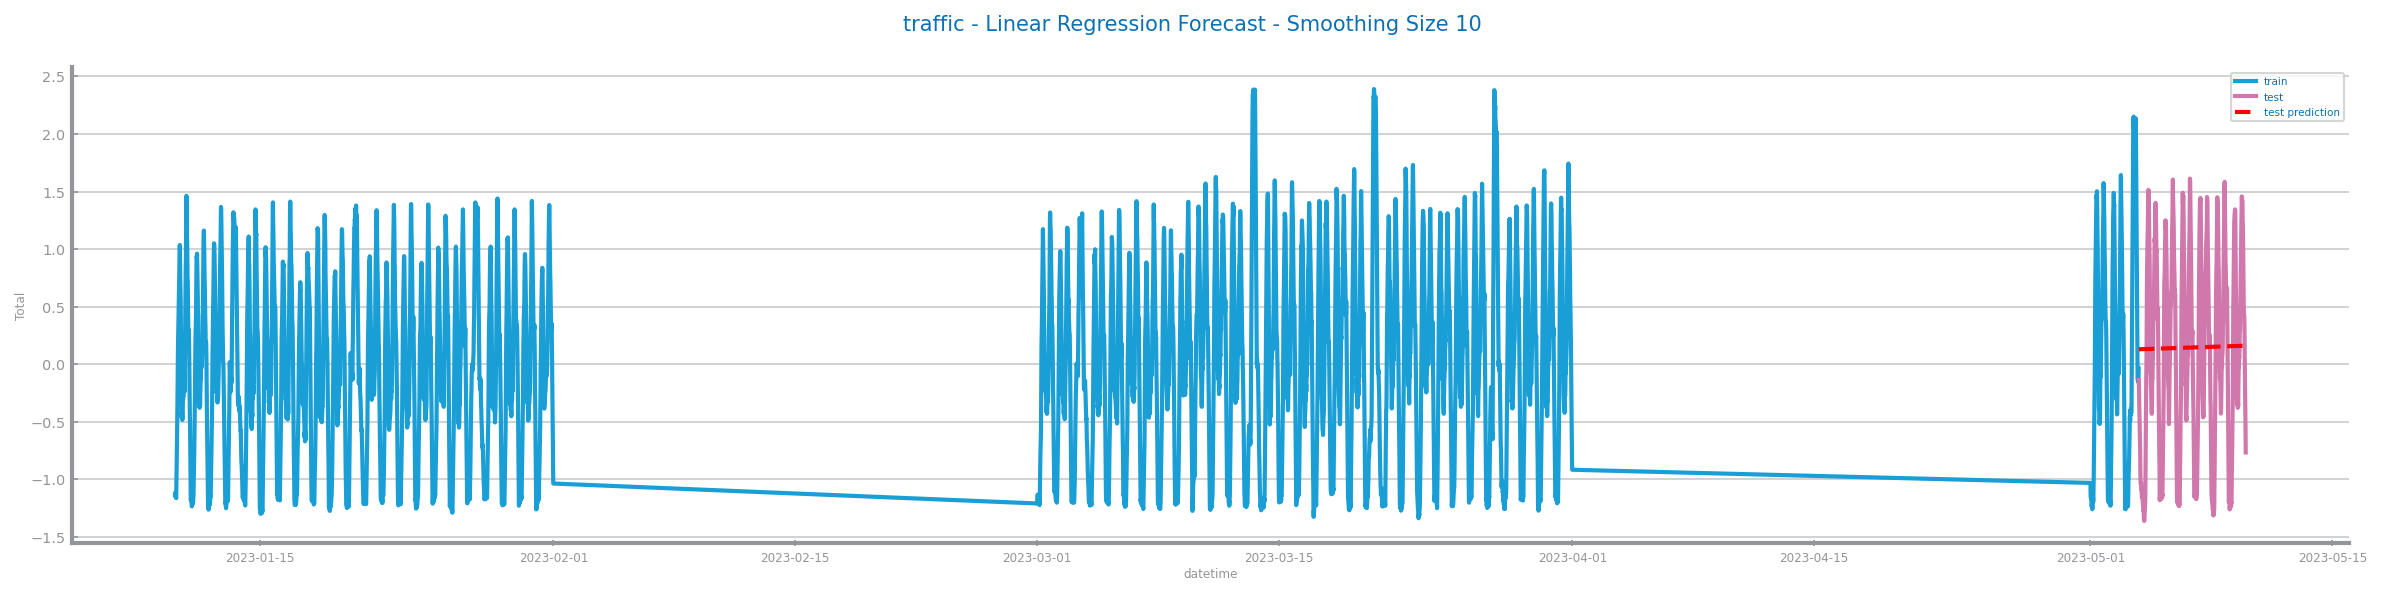

<Figure size 600x450 with 0 Axes>

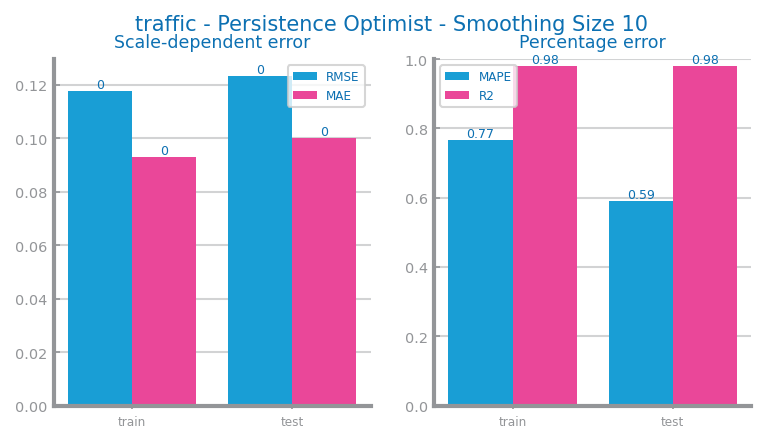

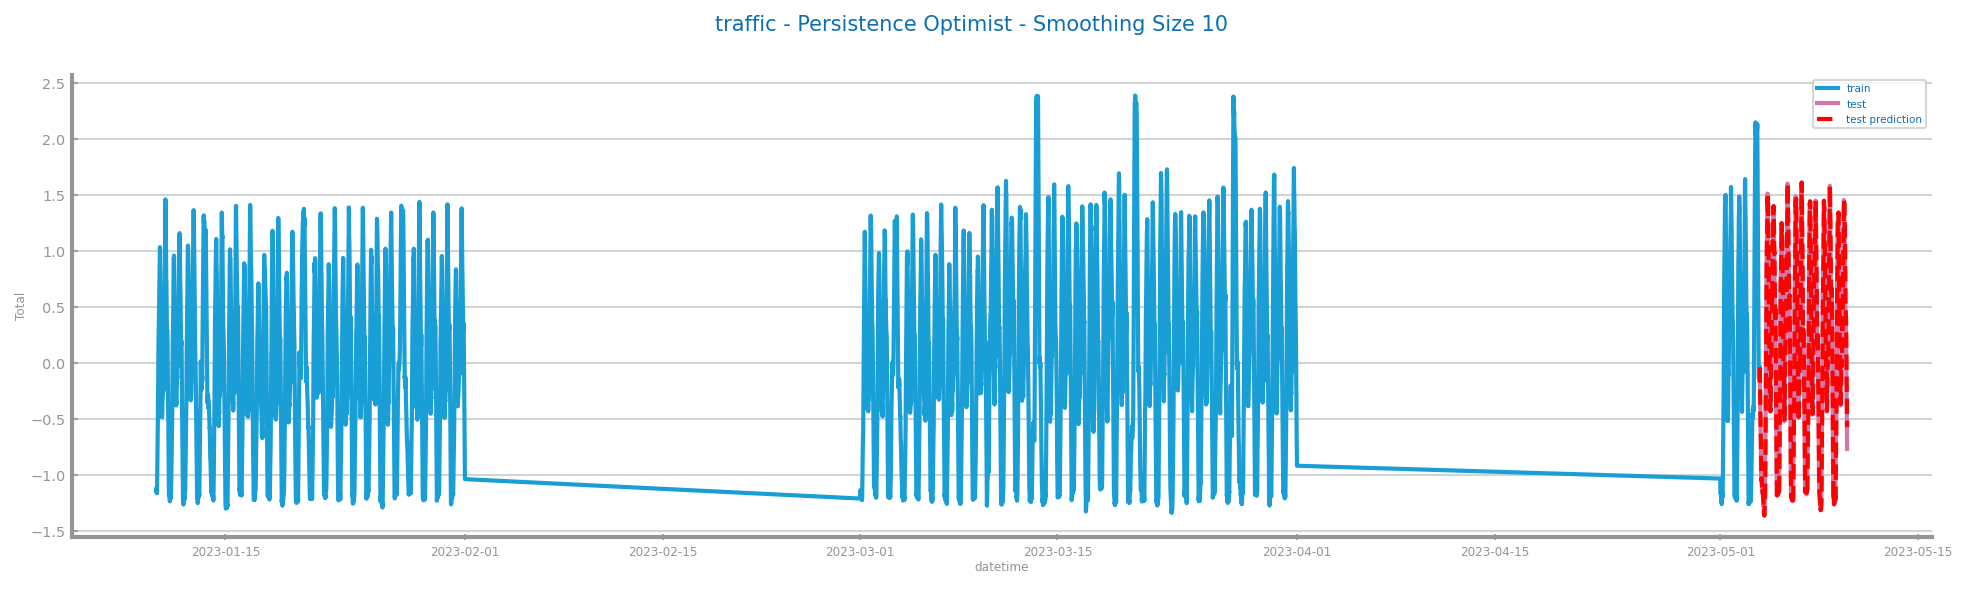

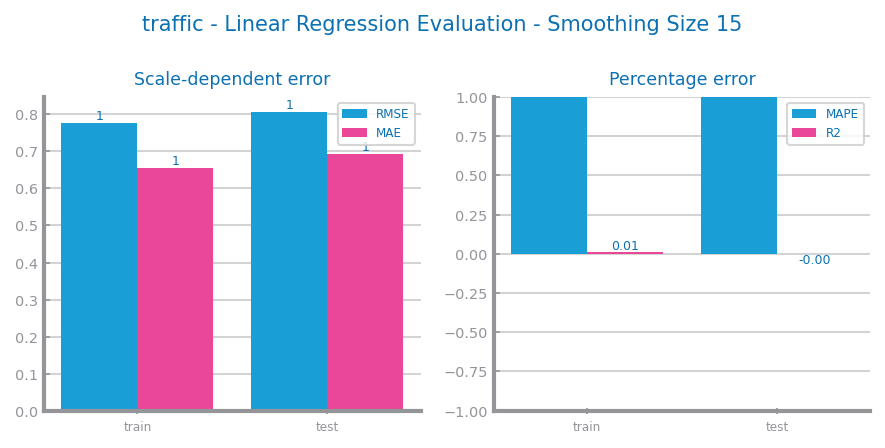

<Figure size 600x450 with 0 Axes>

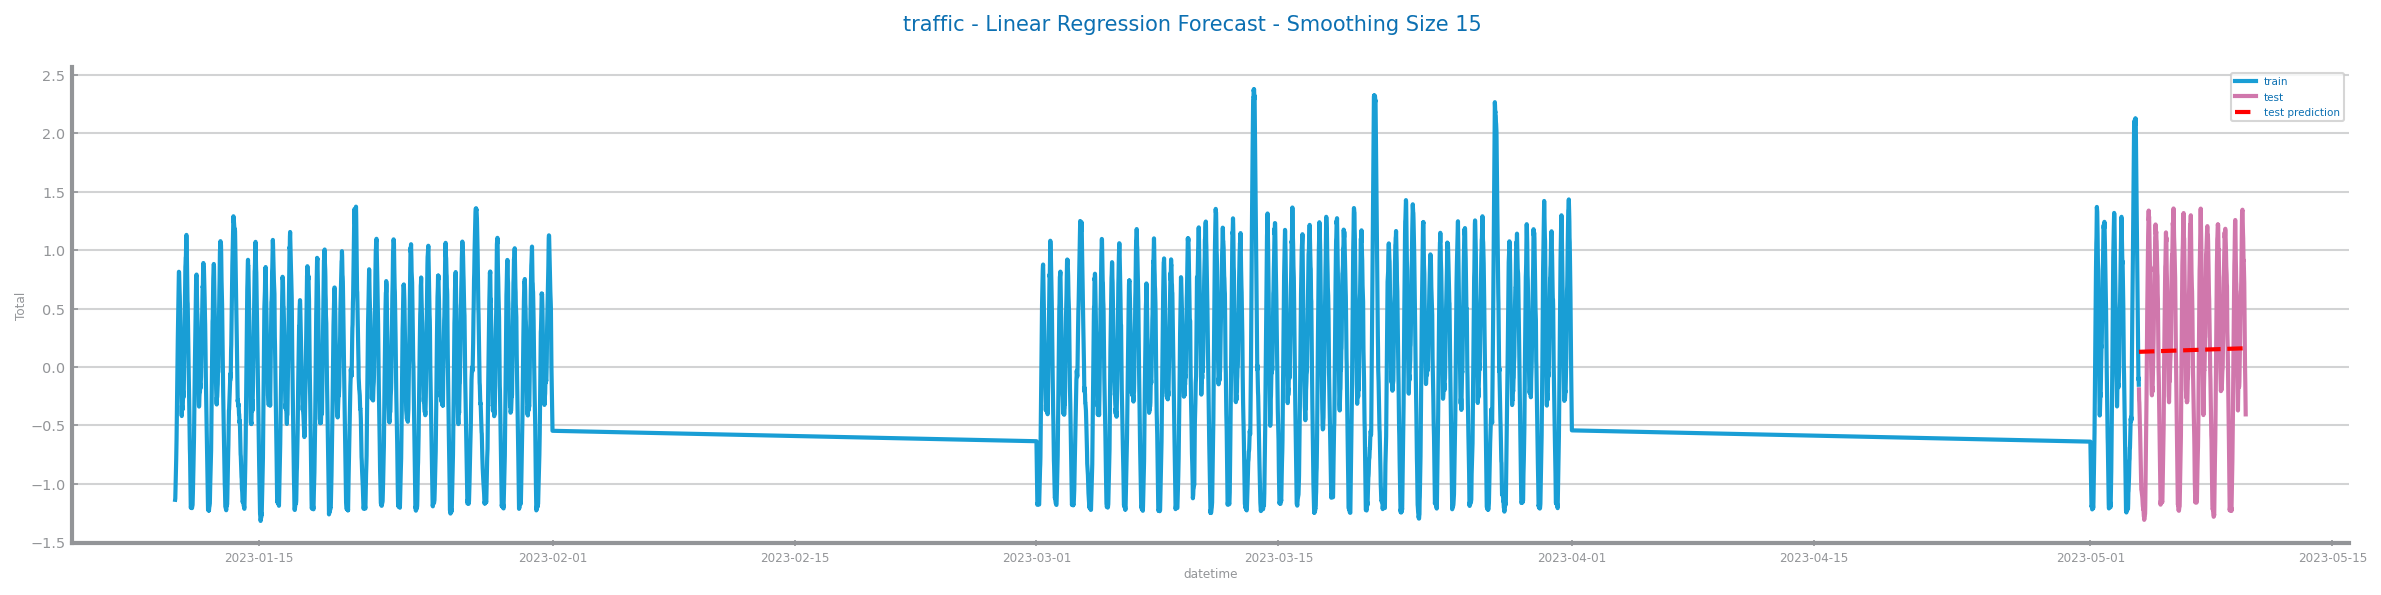

<Figure size 600x450 with 0 Axes>

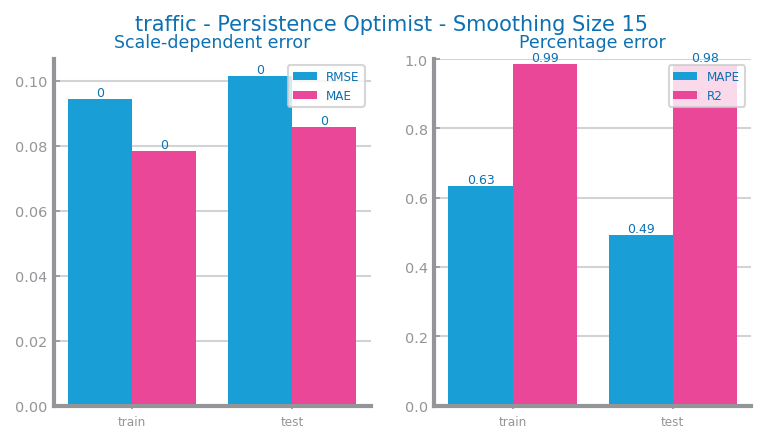

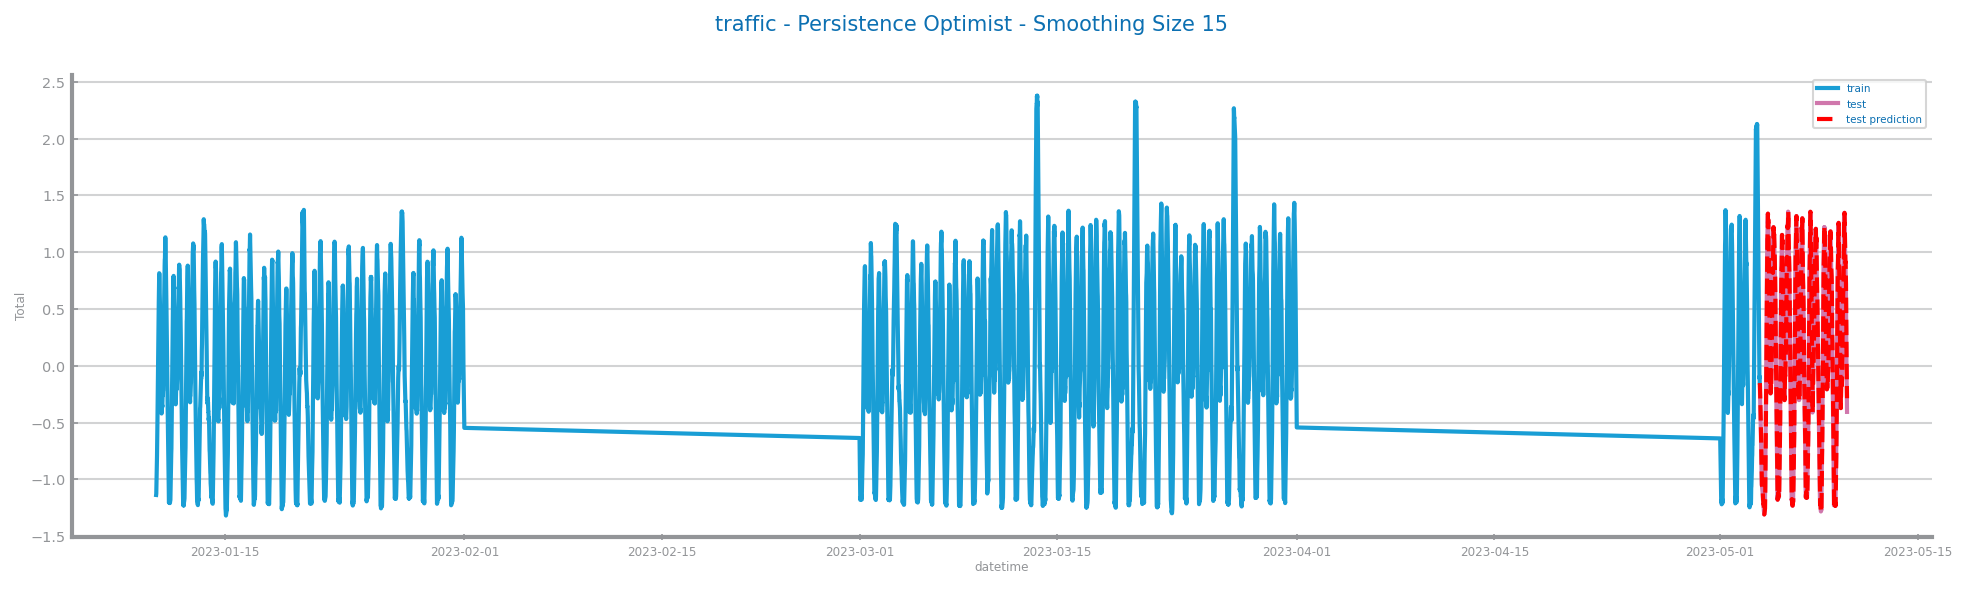

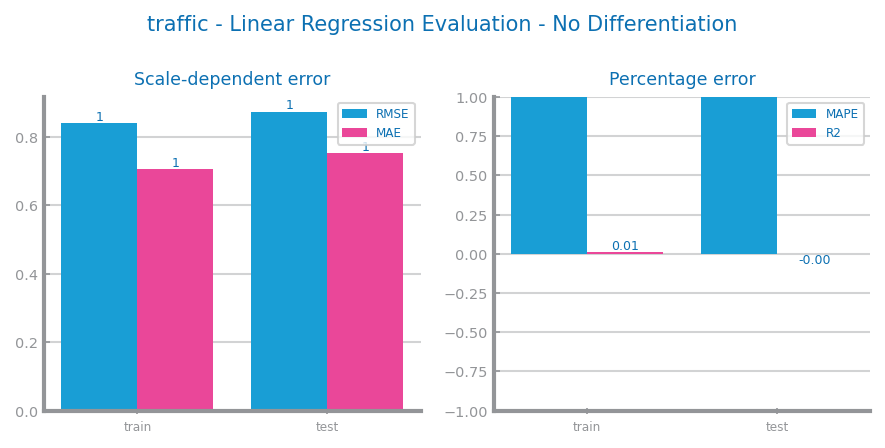

<Figure size 600x450 with 0 Axes>

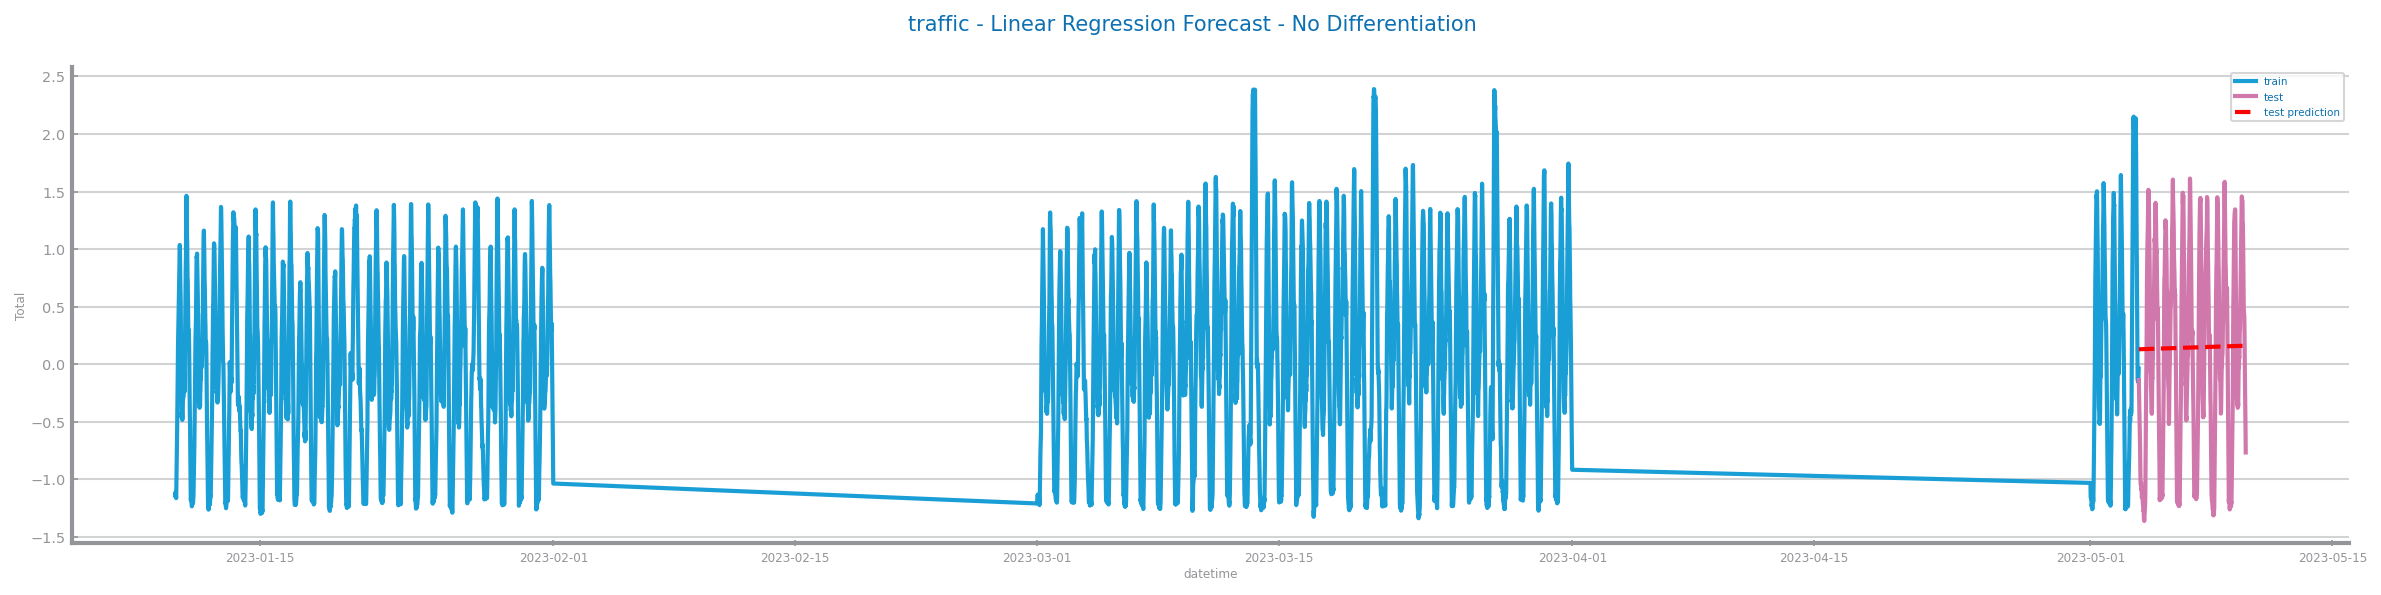

<Figure size 600x450 with 0 Axes>

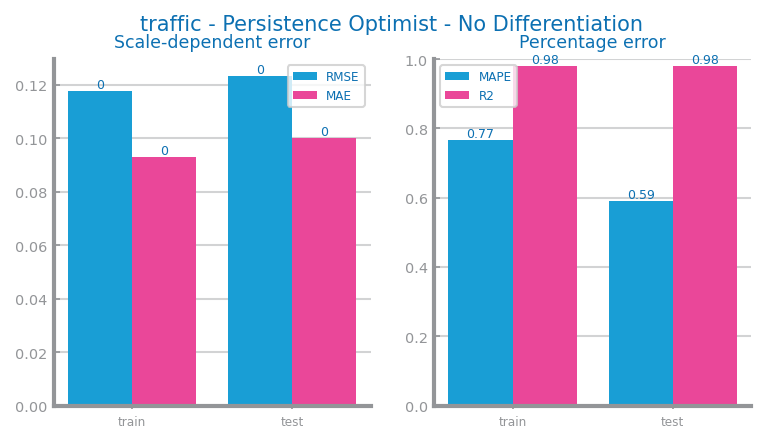

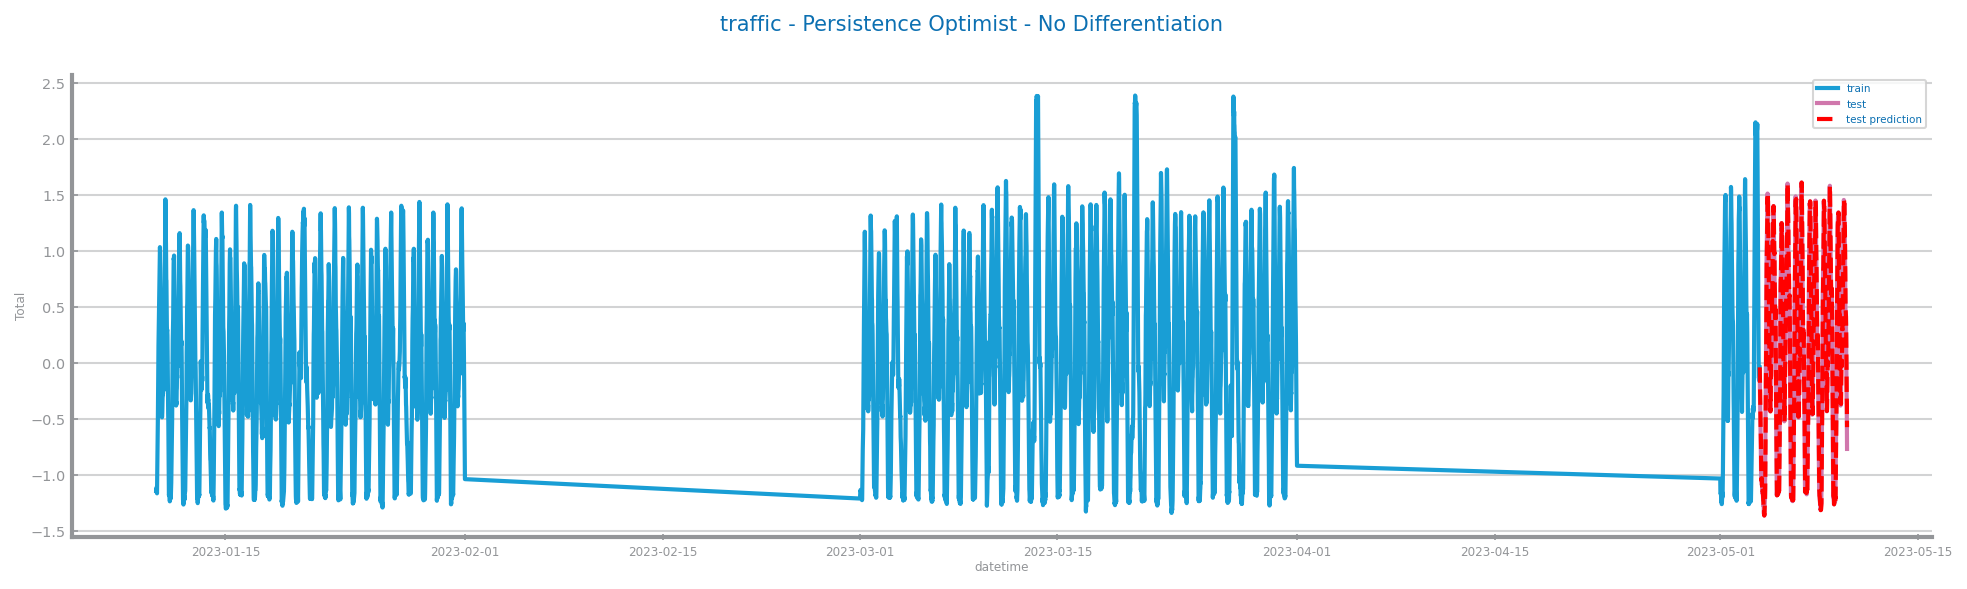

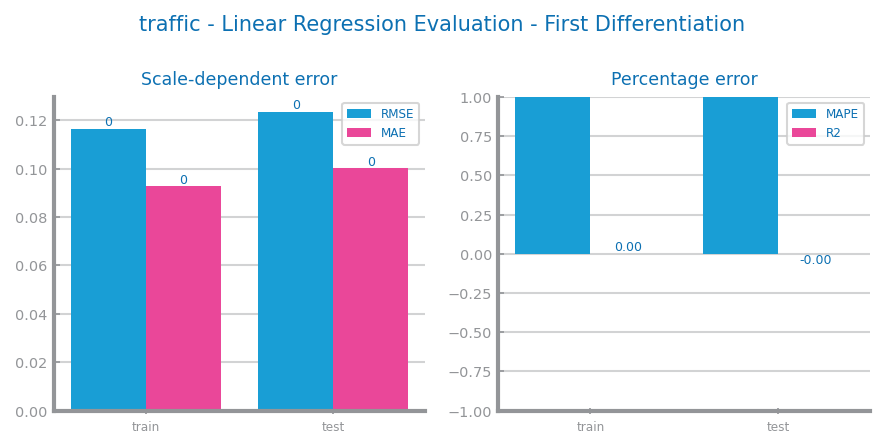

<Figure size 600x450 with 0 Axes>

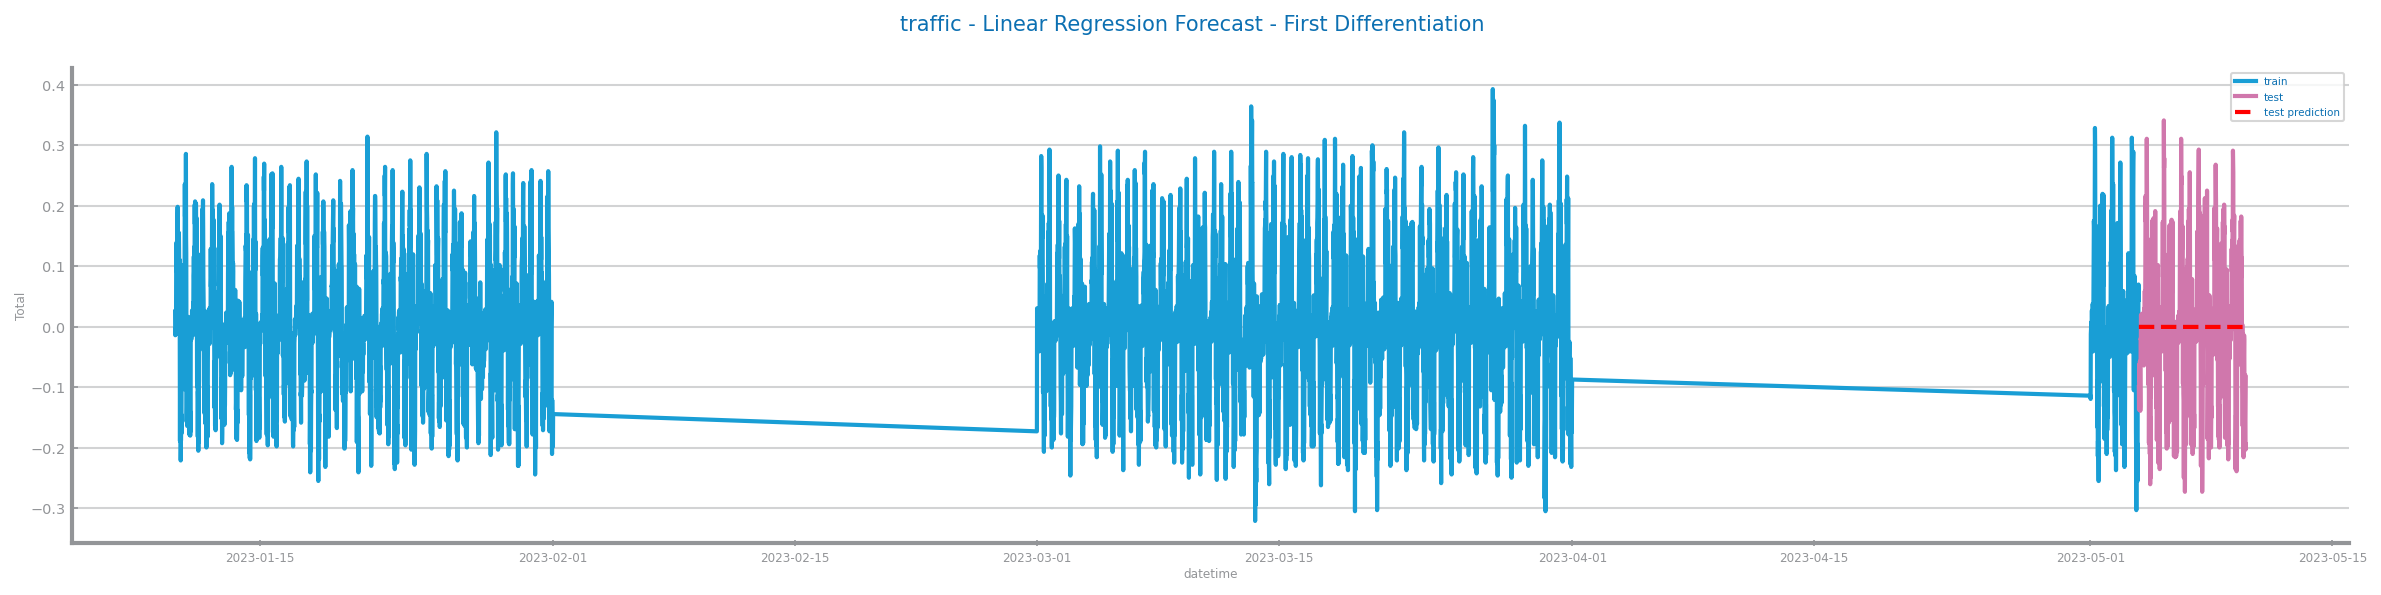

<Figure size 600x450 with 0 Axes>

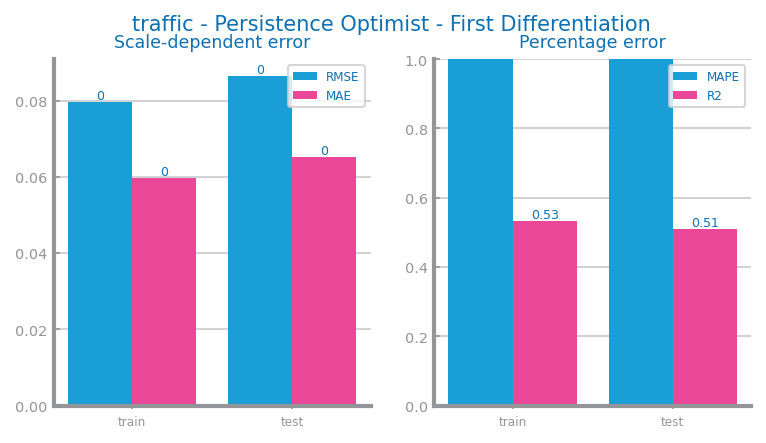

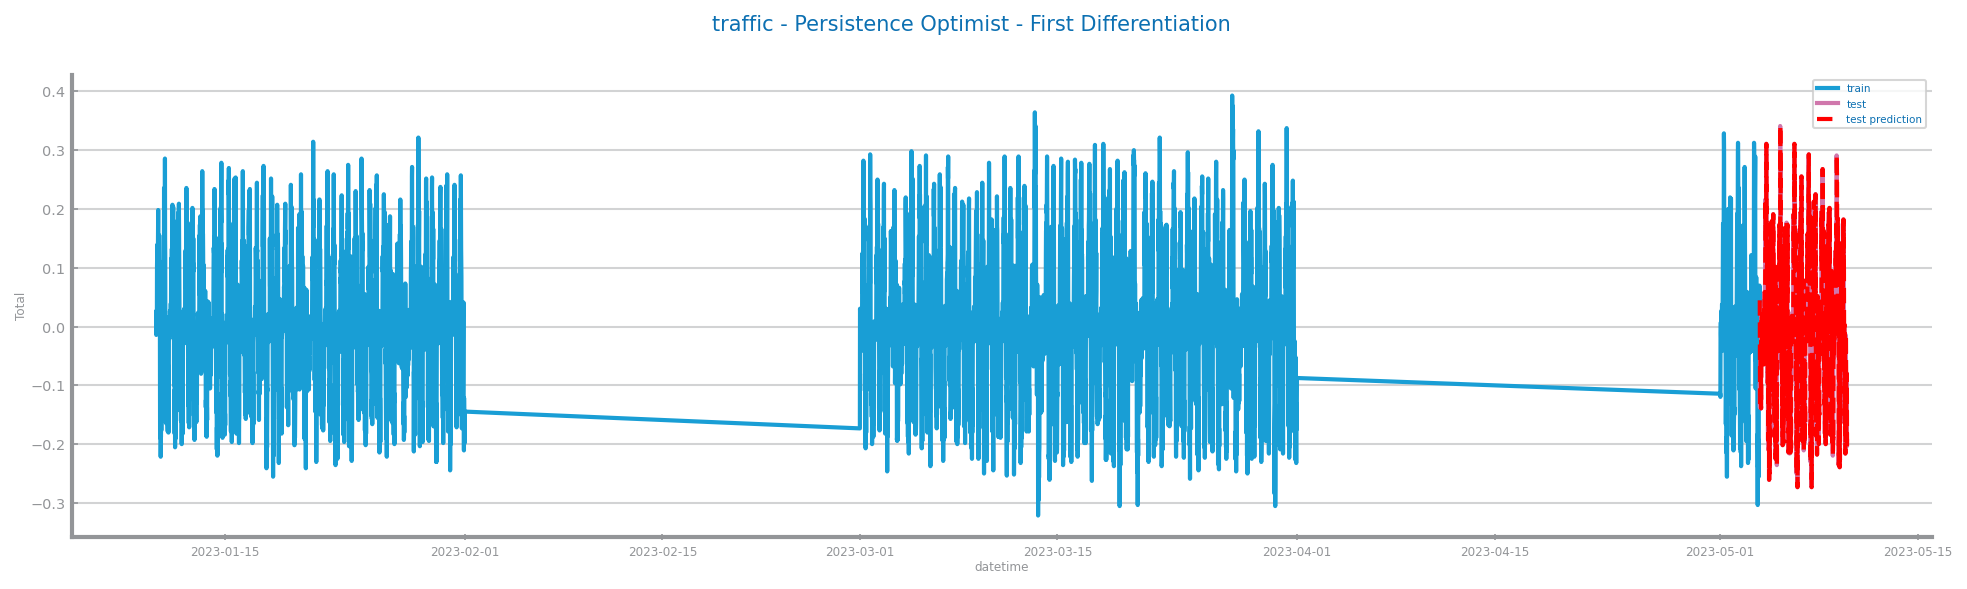

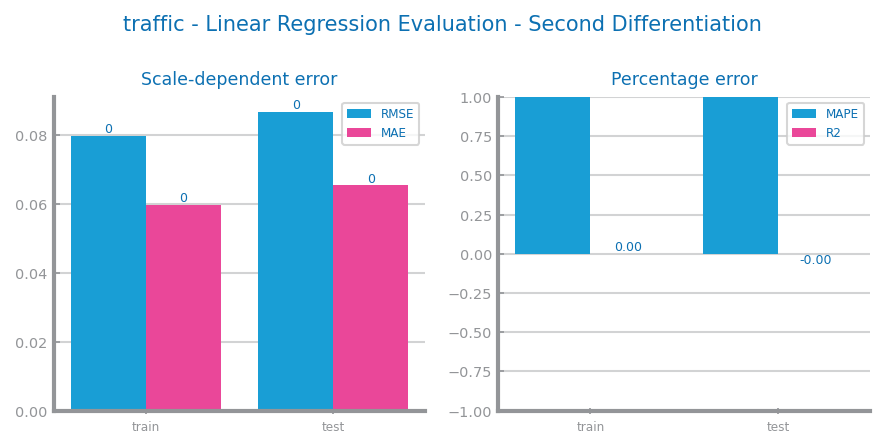

<Figure size 600x450 with 0 Axes>

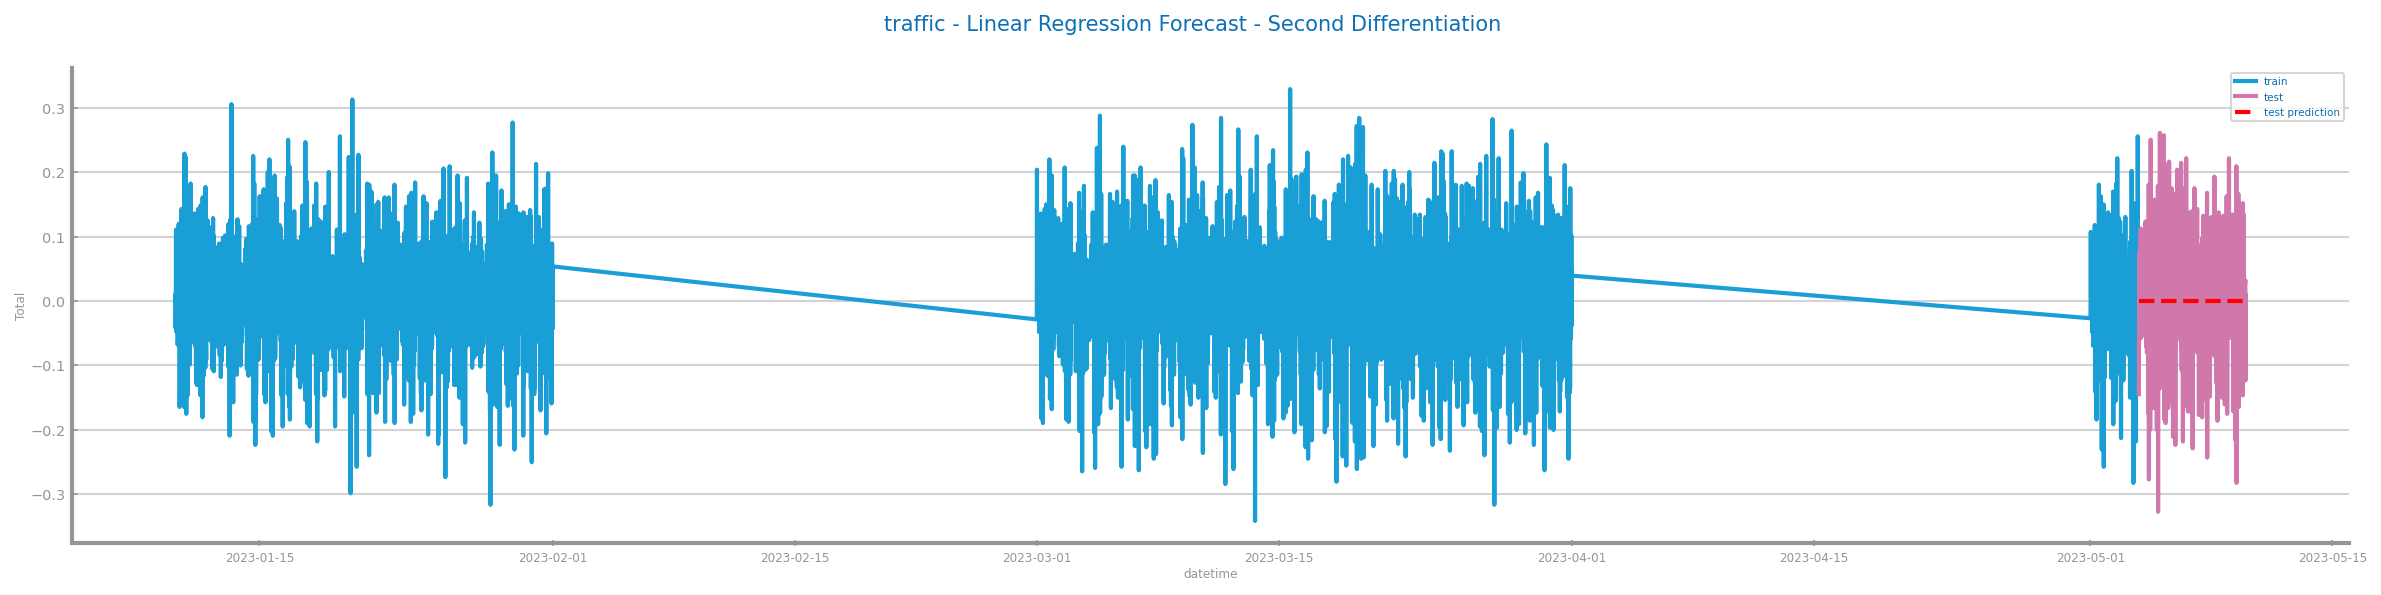

<Figure size 600x450 with 0 Axes>

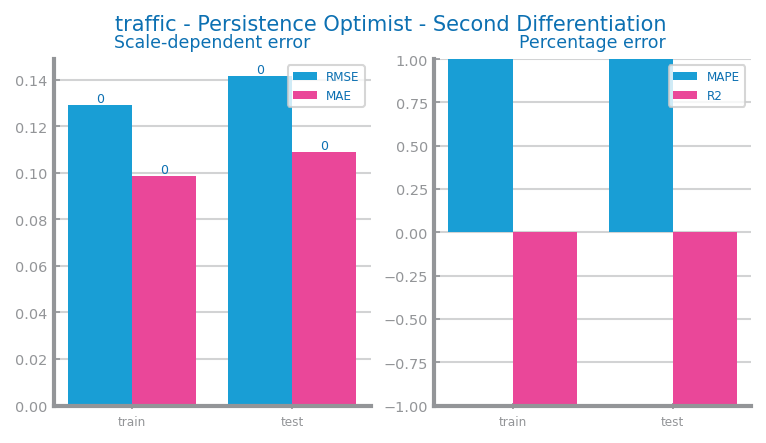

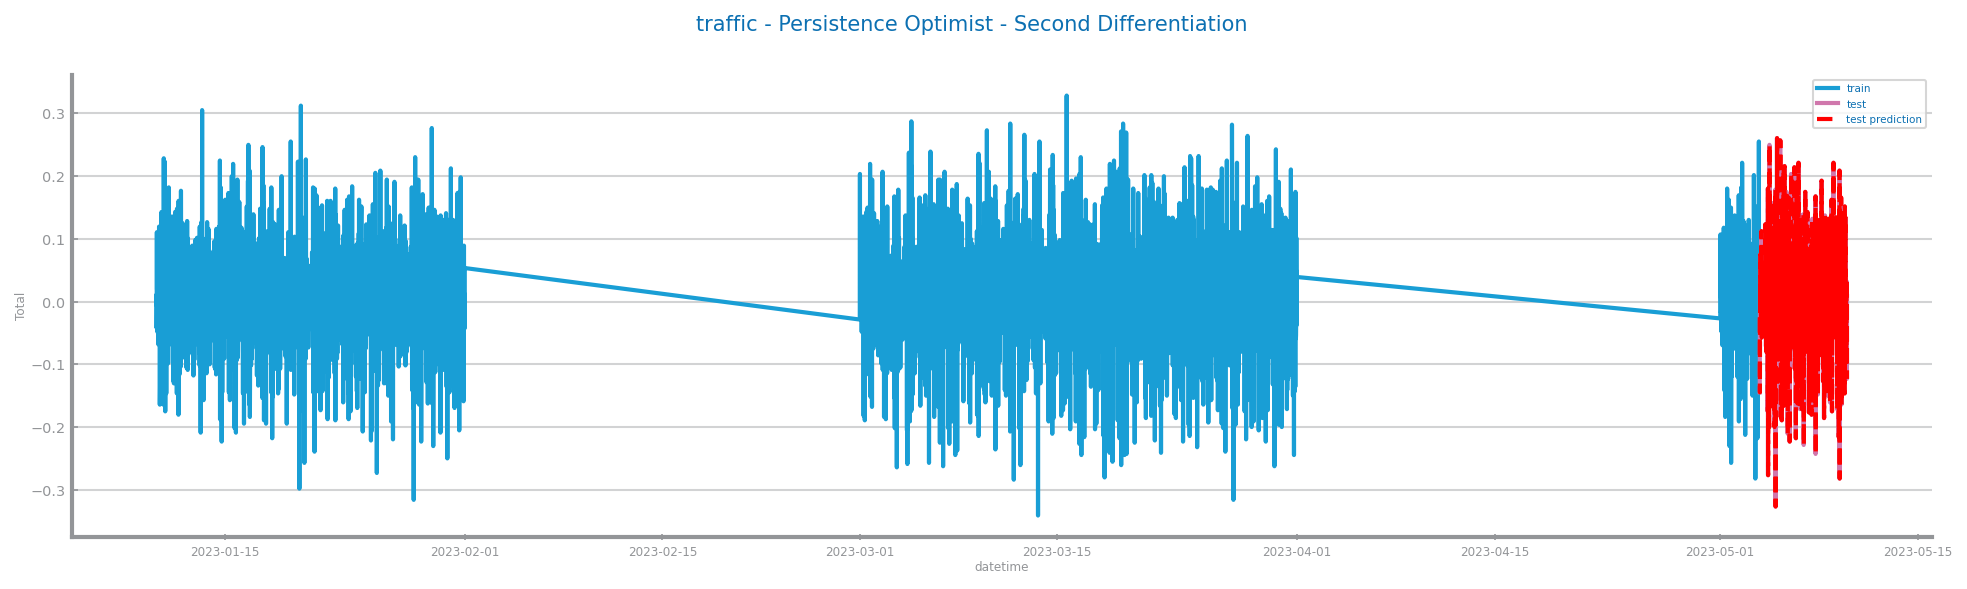

In [14]:
import time

file_tag: str = "traffic"
index_col: str = "datetime"
target: str = "Total"

run_aggregation_study = False
run_smoothing_study = True
run_differentiation_study = True

"""
FASE: Aggregation

% Approach 1: Hourly Aggregation
% Approach 2: Daily Aggregation
% Approach 3: Weekly Aggregation
% Approach 4: 30min Aggregation
% Approach 5: 15min Aggregation
"""
if run_aggregation_study:
    linear_regression_Persistence_evaluation(
        filename="traffic_hourly_aggregated_time.csv",
        file_tag=file_tag,
        index_col=index_col,
        target=target,
        title="Hourly Aggregation"
    )
    time.sleep(5)
    linear_regression_Persistence_evaluation(
        filename="traffic_daily_aggregated_time.csv",
        file_tag=file_tag,
        index_col=index_col,
        target=target,
        title="Daily Aggregation"
    )
    time.sleep(5)
    linear_regression_Persistence_evaluation(
        filename="traffic_weekly_aggregated_time.csv",
        file_tag=file_tag,
        index_col=index_col,
        target=target,
        title="Weekly Aggregation", num=0.7
    )
    time.sleep(5)
    linear_regression_Persistence_evaluation(
        filename="traffic_30MIN_aggregated_time.csv",
        file_tag=file_tag,
        index_col=index_col,
        target=target,
        title="30min Aggregation"
    )
    time.sleep(5)
    linear_regression_Persistence_evaluation(
        filename="/content/traffic_scaled_time.csv",
        file_tag=file_tag,
        index_col=index_col,
        target=target,
        title="15min Aggregation"
    )

"""

Smoothing

% Smoothing Sizes: 3, 5, 10, 15
"""

if run_smoothing_study:
    sizes: list[int] = [3, 5, 10, 15]
    for i in range(len(sizes)):
        linear_regression_Persistence_evaluation(
            filename=f"traffic_smoothed_size_{sizes[i]}_time.csv",
            file_tag=file_tag,
            index_col=index_col,
            target=target,
            title=f"Smoothing Size {sizes[i]}"
        )
        time.sleep(5)

"""
------------------
Differentiation
------------------
% Approach 1: No differentiation
% Approach 2: First differentiation
% Approach 3: Second differentiation
"""
if run_differentiation_study:
    linear_regression_Persistence_evaluation(
        filename="traffic_smoothed_size_10_time.csv",
        file_tag=file_tag,
        index_col=index_col,
        target=target,
        title="No Differentiation"
    )
    linear_regression_Persistence_evaluation(
        filename="traffic_first_diff_time.csv",
        file_tag=file_tag,
        index_col=index_col,
        target=target,
        title="First Differentiation"
    )
    time.sleep(5)
    linear_regression_Persistence_evaluation(
        filename="traffic_second_diff_time.csv",
        file_tag= file_tag,
        index_col=index_col,
        target=target,
        title="Second Differentiation"
    )
    time.sleep(5)

#**Time Series (Sequential)**

In [14]:
from pandas import Series
from sklearn.base import RegressorMixin


class PersistenceOptimistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last: float = 0.0
        return

    def fit(self, X: Series):
        self.last = X.iloc[-1]
        # print(self.last)
        return

    def predict(self, X: Series):
        prd: list = X.shift().values.ravel()
        prd[0] = self.last
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

In [19]:
from dslabs_functions import plot_forecasting_eval,plot_forecasting_series, series_train_test_split
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from numpy import array, ndarray, arange, set_printoptions, log, std
from  pandas import DataFrame, Series


def run_REG_Persistence_study(filename: str, file_tag: str, index_col: str, target: str, title: str, percent: float= 0.9):
    data: DataFrame = read_csv(filename, index_col=index_col)

    series: Series = data[target]
    train, test = series_train_test_split(data,percent)
    print(f"Train: {len(train)}")
    print(f"Test: {len(test)}")
    trnX = arange(len(train)).reshape(-1, 1)
    trnY = train.to_numpy()
    tstX = arange(len(train), len(data)).reshape(-1, 1)
    tstY = test.to_numpy()

    model = LinearRegression()
    model.fit(trnX, trnY)

    prd_trn: Series = Series(model.predict(trnX).reshape(-1), index=train.index)
    prd_tst: Series = Series(model.predict(tstX).reshape(-1), index=test.index)

    plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression Evaluation - {title}")
    plt.tight_layout()
    plt.savefig(f"i/{file_tag}_linear_regression_evaluation_{title}.png")
    plt.show()
    plt.clf()

    plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - Linear Regression Forecast - {title}",
        xlabel=index_col,
        ylabel=target,
    )
    plt.tight_layout()
    plt.savefig(f"i/{file_tag}_linear_regression_forecast_{title}.png")
    plt.show()
    plt.clf()
    # Persistence
    fr_mod = PersistenceOptimistRegressor()

    fr_mod = PersistenceOptimistRegressor()
    fr_mod.fit(train)


    prd_trn = fr_mod.predict(train)
    prd_tst = fr_mod.predict(test)

    plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Persistence Optimist - {title}")
    savefig(f"i/{file_tag}_persistence_optim_eval_{title}.png")

    plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Persistence Optimist - {title}",
    xlabel= index_col,
    ylabel=target,
    )
    savefig(f"i/{file_tag}_persistence_optim_forecast__{title}.png")

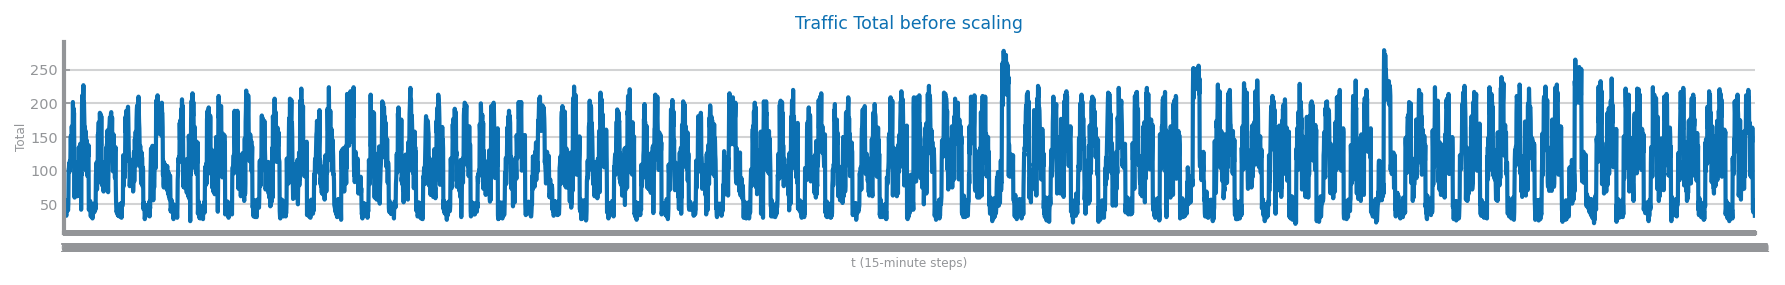

<Figure size 600x450 with 0 Axes>

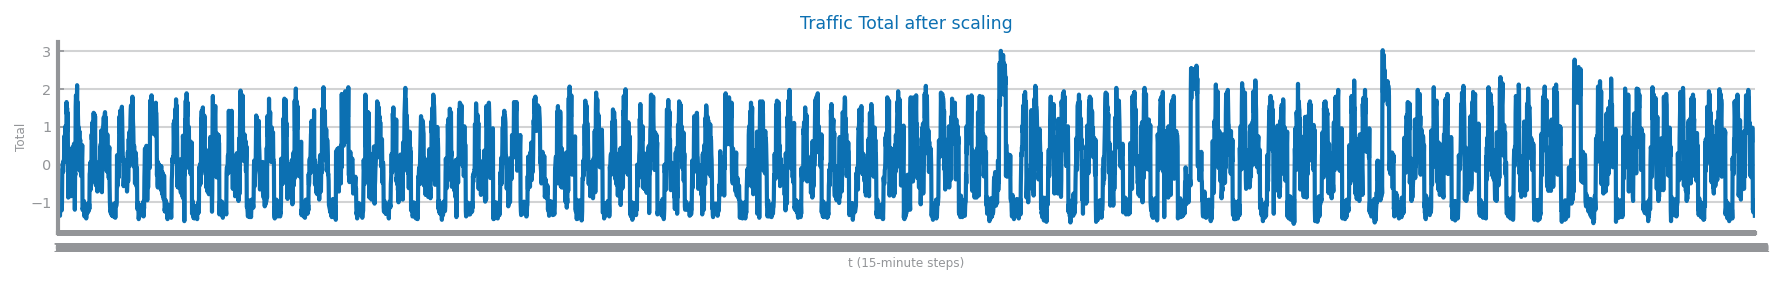

<Figure size 600x450 with 0 Axes>

In [15]:
# =====================================================
# TRAFFIC STATUS PREDICTION — Time Series (Sequential)
# =====================================================

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame, Series
from dslabs_functions import plot_line_chart, HEIGHT

def scale_all_dataframe(data: DataFrame) -> DataFrame:
    vars: list[str] = data.columns.to_list()
    transf: StandardScaler = StandardScaler().fit(data)
    df = DataFrame(transf.transform(data), index=data.index)
    df.columns = vars
    return df

file_tag: str = "Traffic"
target: str = "Total"

# Load data
traffic_data: DataFrame = read_csv("/content/traffic_encoding.csv")

# Create sequential time index
traffic_data["t"] = range(len(traffic_data))
traffic_data = traffic_data.set_index("t")

# Remove original date/time columns
traffic_data = traffic_data.drop(columns=["Date", "Time","Day of the week"])

# Extract target series
series: Series = traffic_data[target]

# Before scaling
plt.figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel="t (15-minute steps)",
    ylabel=target,
    title=f"{file_tag} {target} before scaling",
)
plt.tight_layout()
plt.savefig(f"{file_tag}_before_scaling.png")
plt.show()
plt.clf()

# After scaling
df: DataFrame = scale_all_dataframe(traffic_data)
ss: Series = df[target]

plt.figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    ss.index.to_list(),
    ss.to_list(),
    xlabel="t (15-minute steps)",
    ylabel=target,
    title=f"{file_tag} {target} after scaling",
)
plt.tight_layout()
plt.savefig(f"{file_tag}_after_scaling.png")
plt.show()
plt.clf()

# Save scaled data
df.to_csv("traffic_scaled.csv")


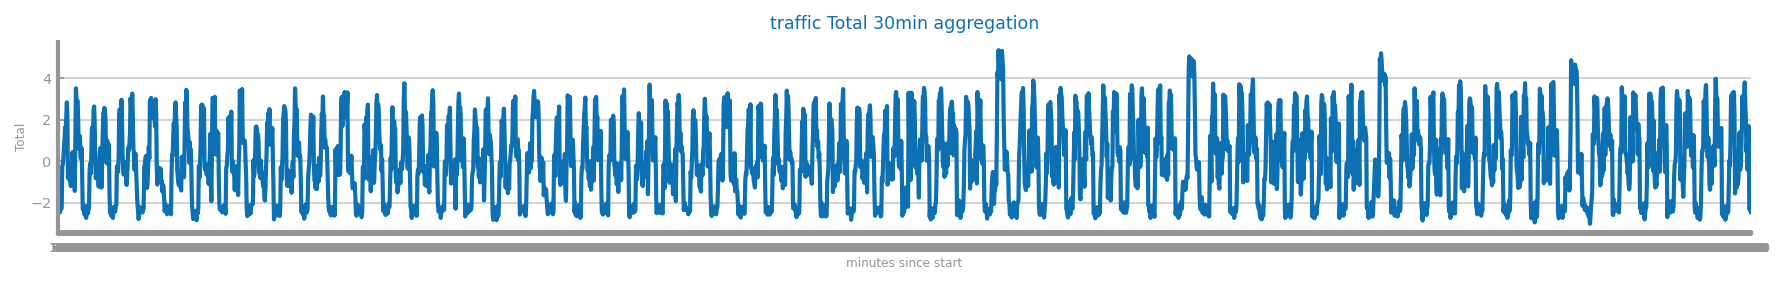

<Figure size 600x450 with 0 Axes>

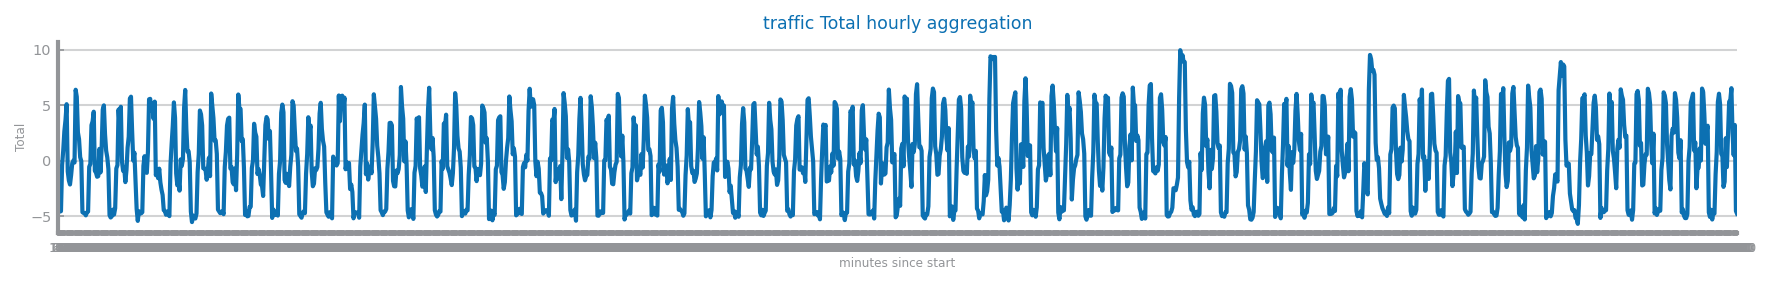

<Figure size 600x450 with 0 Axes>

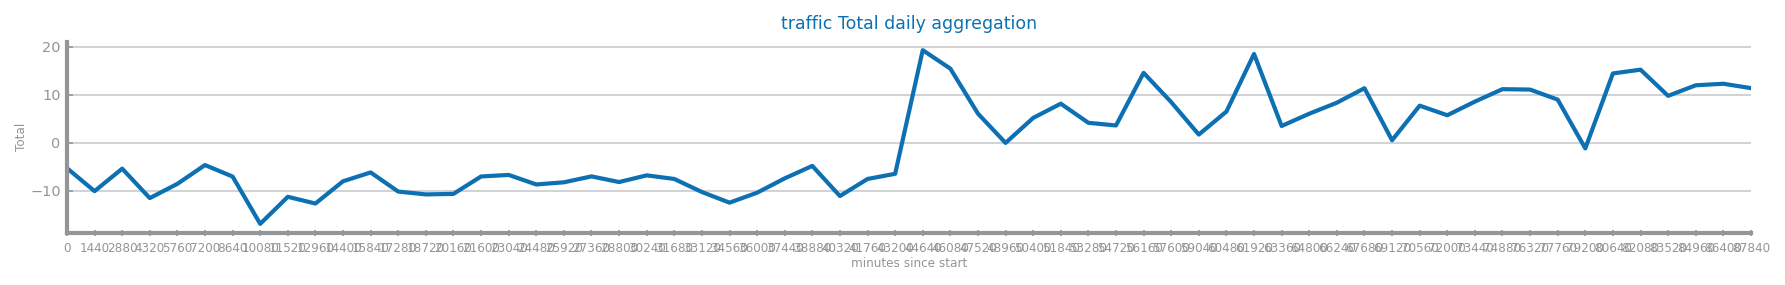

<Figure size 600x450 with 0 Axes>

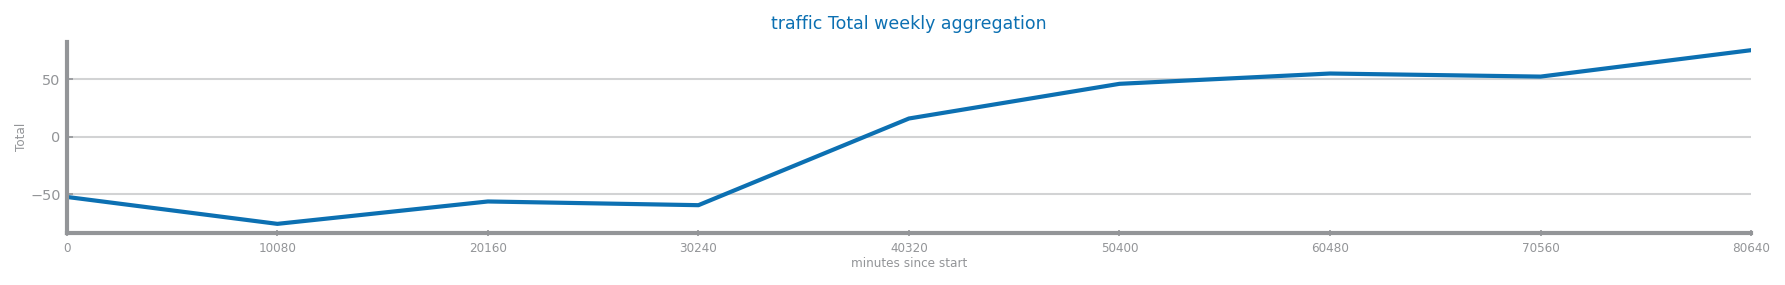

<Figure size 600x450 with 0 Axes>

In [16]:
# =====================================================
# TRAFFIC STATUS PREDICTION — Time Series (Aggregation)
# =====================================================

import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame, Series
from dslabs_functions import HEIGHT, plot_line_chart

filename: str = "traffic_scaled.csv"
file_tag: str = "traffic"
target: str = "Total"

traffic_data: DataFrame = read_csv(filename, index_col="t")
series: Series = traffic_data[target]

# (cada step = 15 min)
grans = {
    "30min": 2,
    "hourly": 4,
    "daily": 96,
    "weekly": 672
}

def ts_aggregation_by_seq(
    data: Series | DataFrame,
    steps: int,
    agg_func: str = "mean",
) -> Series | DataFrame:
    df = data.copy()
    groups = df.index // steps
    df = df.groupby(groups).agg(agg_func)
    df.index = df.index * steps * 15
    return df

for gran, steps in grans.items():
    traffic_data_gran = ts_aggregation_by_seq(series, steps=steps, agg_func="sum")

    plt.figure(figsize=(3 * HEIGHT, HEIGHT / 2))
    plot_line_chart(
        traffic_data_gran.index.to_list(),
        traffic_data_gran.to_list(),
        xlabel="minutes since start",
        ylabel=target,
        title=f"{file_tag} {target} {gran} aggregation",
    )
    plt.tight_layout()
    plt.savefig(f"i/{file_tag}_{gran}_aggregation.png")
    plt.show()
    plt.clf()

    traffic_data_gran.to_csv(f"i/traffic_{gran}_aggregated.csv")



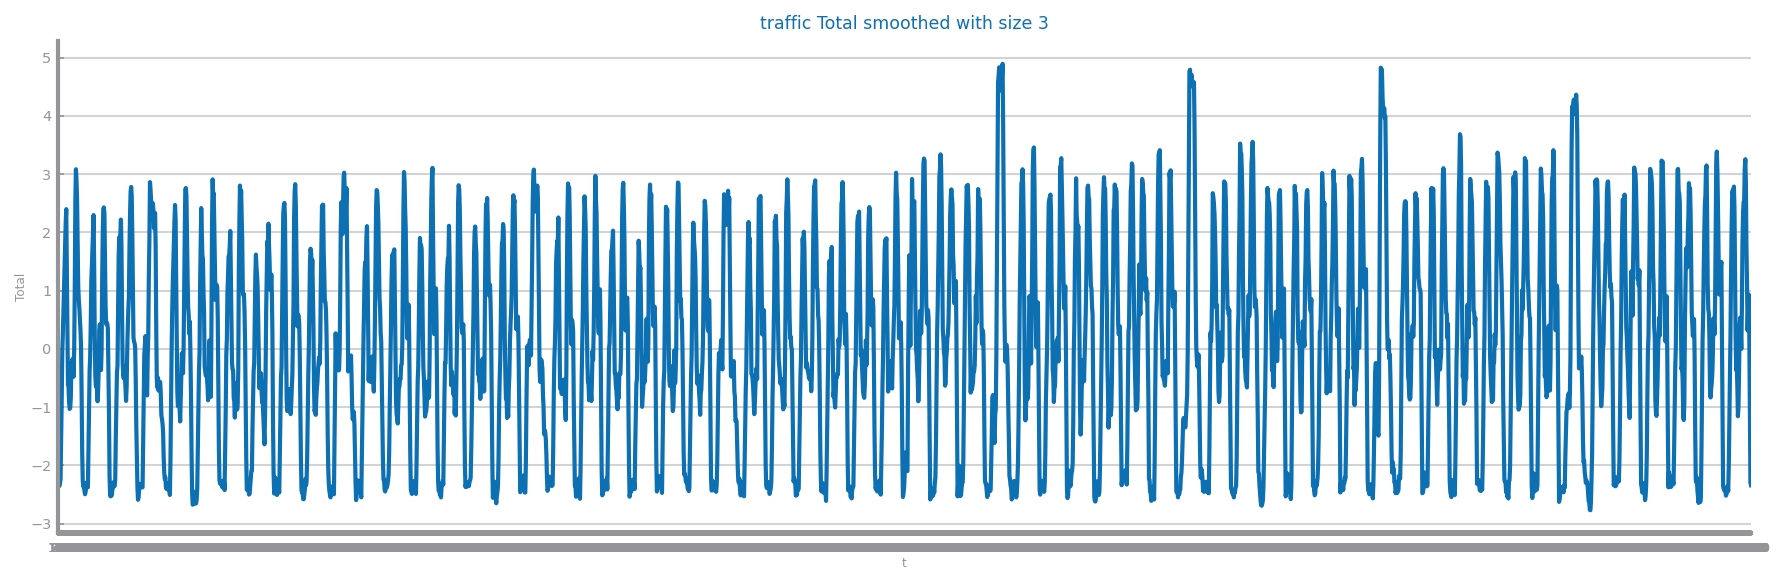

<Figure size 600x450 with 0 Axes>

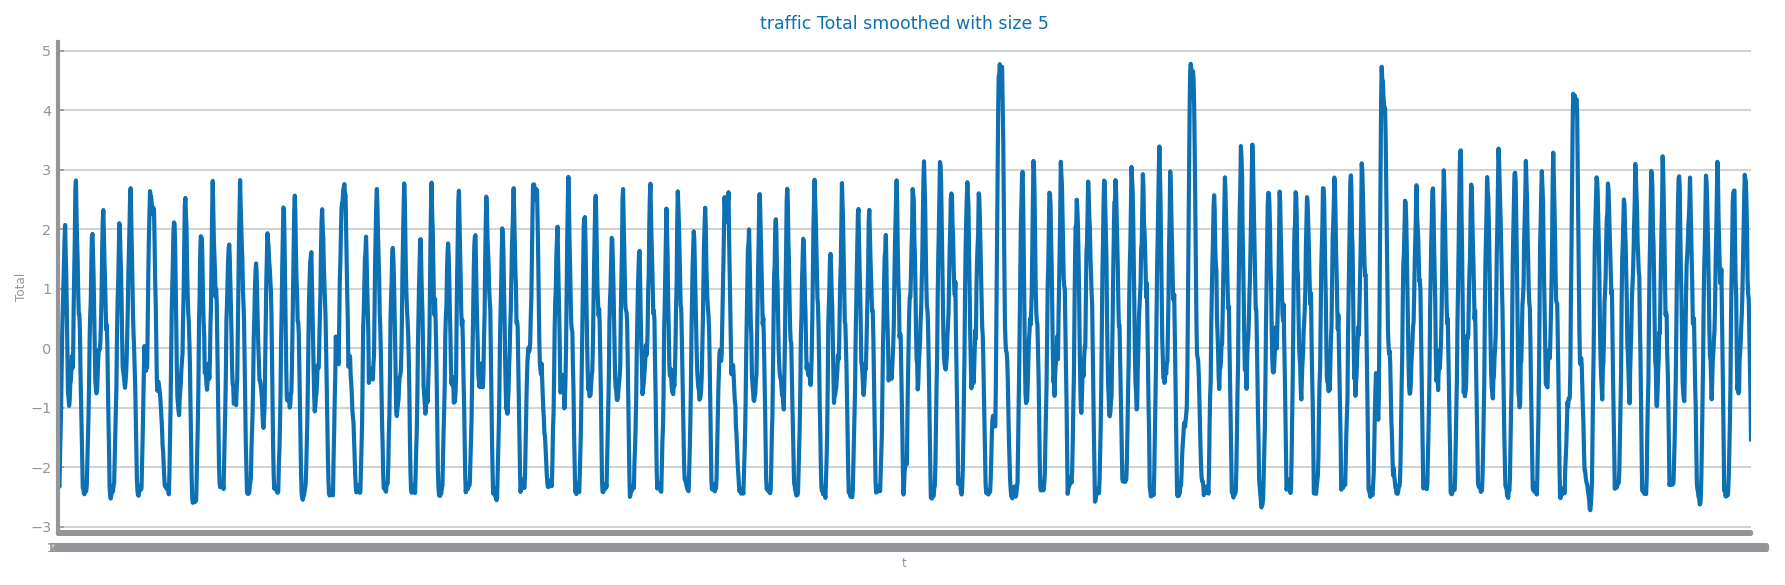

<Figure size 600x450 with 0 Axes>

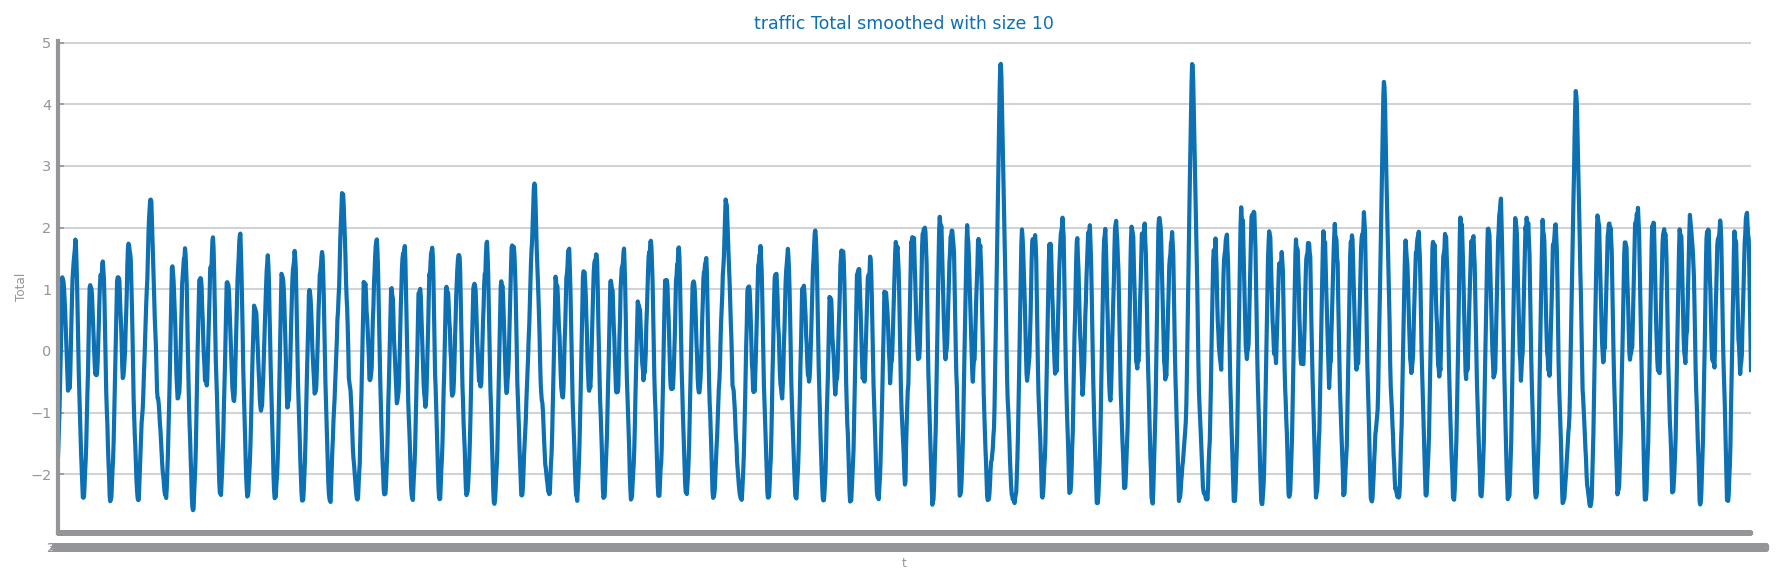

<Figure size 600x450 with 0 Axes>

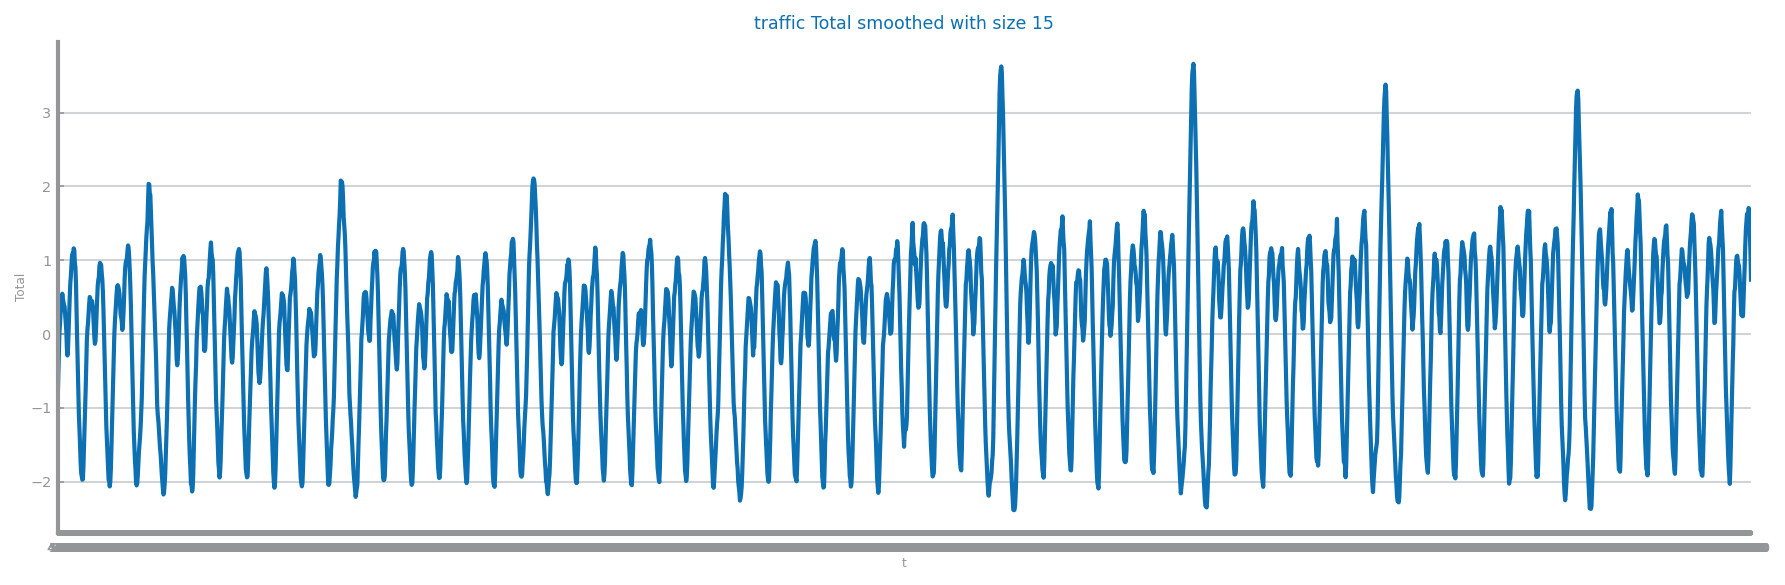

<Figure size 600x450 with 0 Axes>

In [21]:
# =====================================================
# TRAFFIC STATUS PREDICTION — Time Series (Smoothing)
# =====================================================~

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from pandas import DataFrame, read_csv, Series
from dslabs_functions import plot_line_chart, HEIGHT

filename: str = "i/traffic_30min_aggregated.csv"
file_tag: str = "traffic"
index_col: str = "t"
target: str = "Total"
traffic_data: DataFrame = read_csv(filename, index_col=index_col)

series: Series = traffic_data[target]

sizes: list[int] = [3, 5, 10, 15]

for i in range(len(sizes)):
    fig = plt.figure(figsize=(3 * HEIGHT, HEIGHT))
    ss_smooth: Series = series.rolling(window=sizes[i]).mean().dropna()
    plot_line_chart(
        ss_smooth.index.to_list(),
        ss_smooth.to_list(),
        xlabel=ss_smooth.index.name,
        ylabel=target,
        title=f"{file_tag} {target} smoothed with size {sizes[i]}",
    )
    plt.tight_layout()
    plt.savefig(f"i/{file_tag}_smoothed_size_{sizes[i]}.png")
    plt.show()
    plt.clf()

    # Save smoothed data
    ss_smooth.to_csv(f"{file_tag}_smoothed_size_{sizes[i]}.csv")

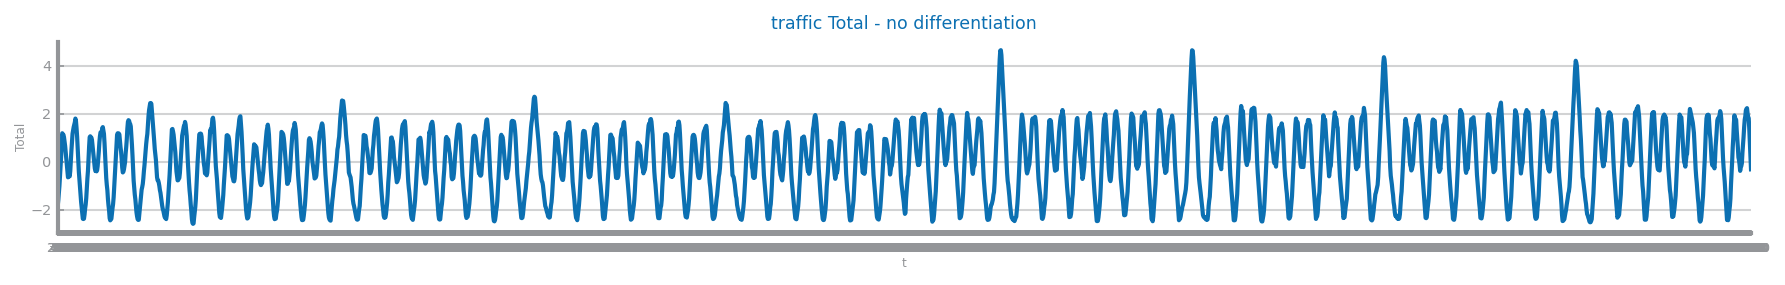

<Figure size 600x450 with 0 Axes>

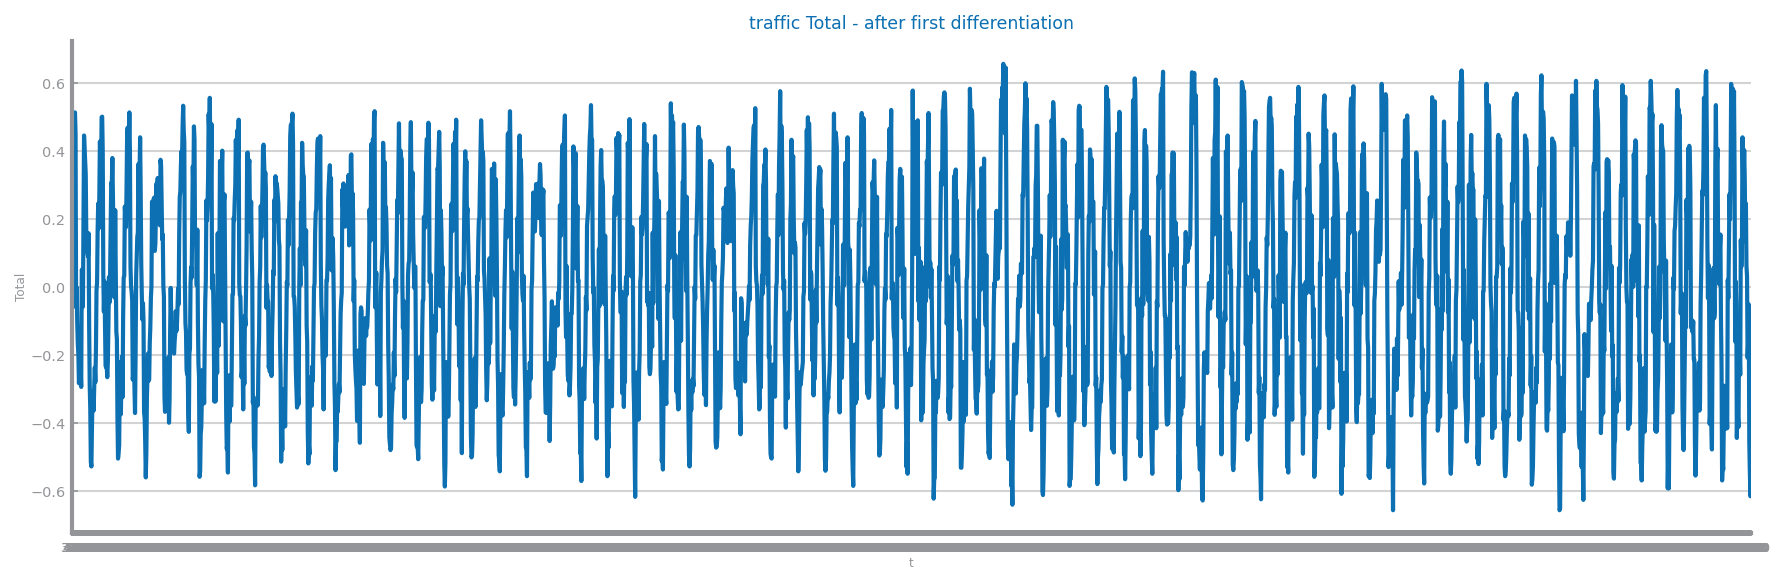

<Figure size 600x450 with 0 Axes>

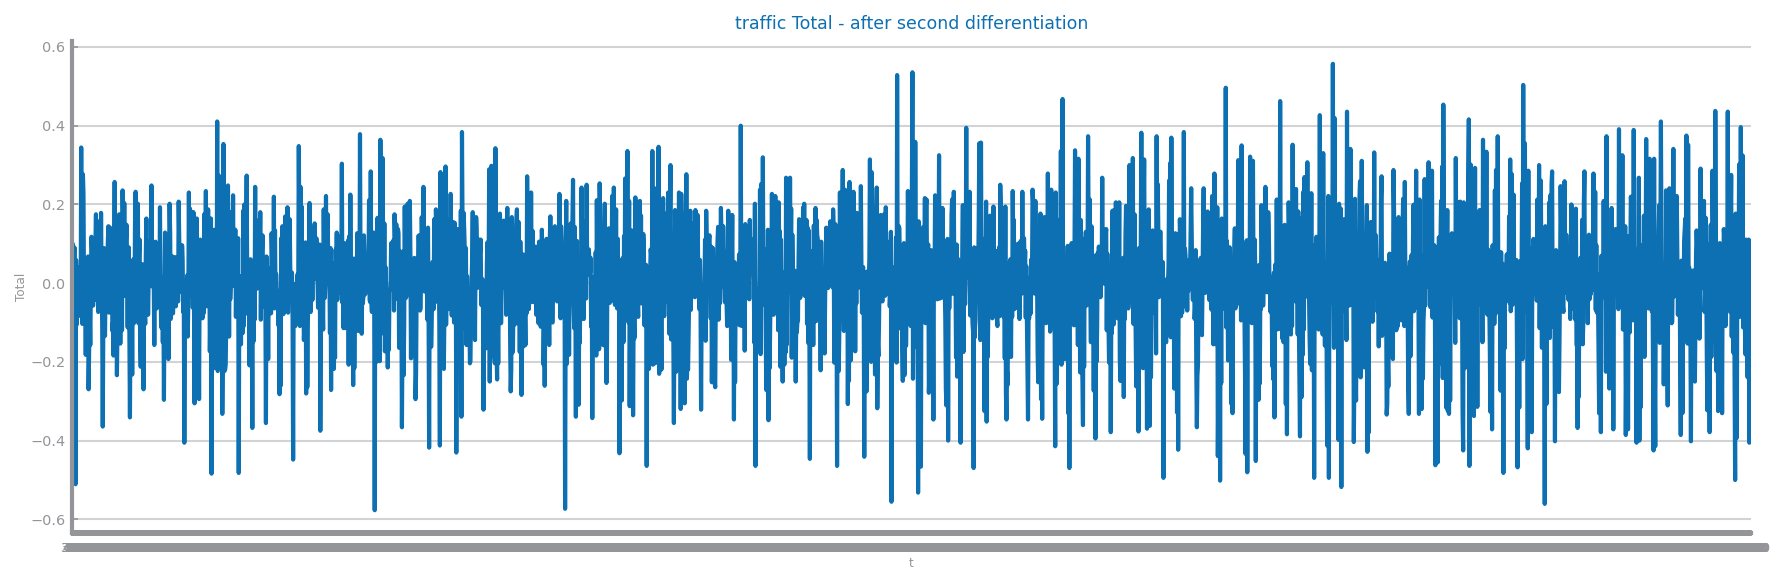

<Figure size 600x450 with 0 Axes>

In [23]:
# =====================================================
# TRAFFIC STATUS PREDICTION — Time Series (Differentiation)
# =====================================================

import matplotlib.pyplot as plt
from pandas import DataFrame, read_csv, Series

from dslabs_functions import HEIGHT, plot_line_chart

filename: str = "traffic_smoothed_size_10.csv"
file_tag: str = "traffic"
index_col: str = "t"
target: str = "Total"
traffic_data: DataFrame = read_csv(filename, index_col=index_col)
series: Series = traffic_data[target]

# ----------------------------
# No differentiation
# ----------------------------

plt.figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} {target} - no differentiation",
)
plt.tight_layout()
plt.savefig(f"i/{file_tag}_no_diff.png")
plt.show()
plt.clf()

# ----------------------------
# First differentiation
# ----------------------------

ss_diff: Series = series.diff().dropna()

plt.figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_diff.index.to_list(),
    ss_diff.to_list(),
    title=f"{file_tag} {target} - after first differentiation",
    xlabel=series.index.name,
    ylabel=target,
)
plt.tight_layout()
plt.savefig(f"i/{file_tag}_first_diff.png")
plt.show()
plt.clf()

ss_diff.to_csv(f"traffic_first_diff.csv")

# ----------------------------
# Second differentiation
# ----------------------------
ss_diff: Series = ss_diff.diff().dropna()

plt.figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_diff.index.to_list(),
    ss_diff.to_list(),
    title=f"{file_tag} {target} - after second differentiation",
    xlabel=series.index.name,
    ylabel=target,
)
plt.tight_layout()
plt.savefig(f"i/{file_tag}_second_diff.png")
plt.show()
plt.clf()

ss_diff.to_csv(f"traffic_second_diff.csv")

Train: 2670
Test: 297


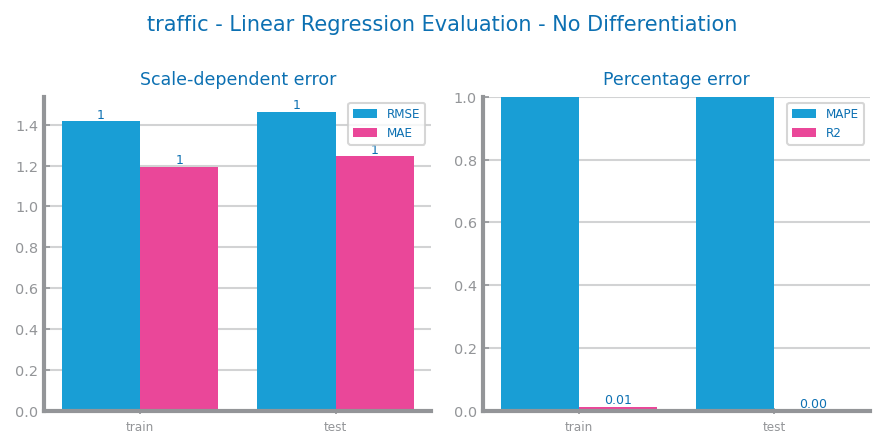

<Figure size 600x450 with 0 Axes>

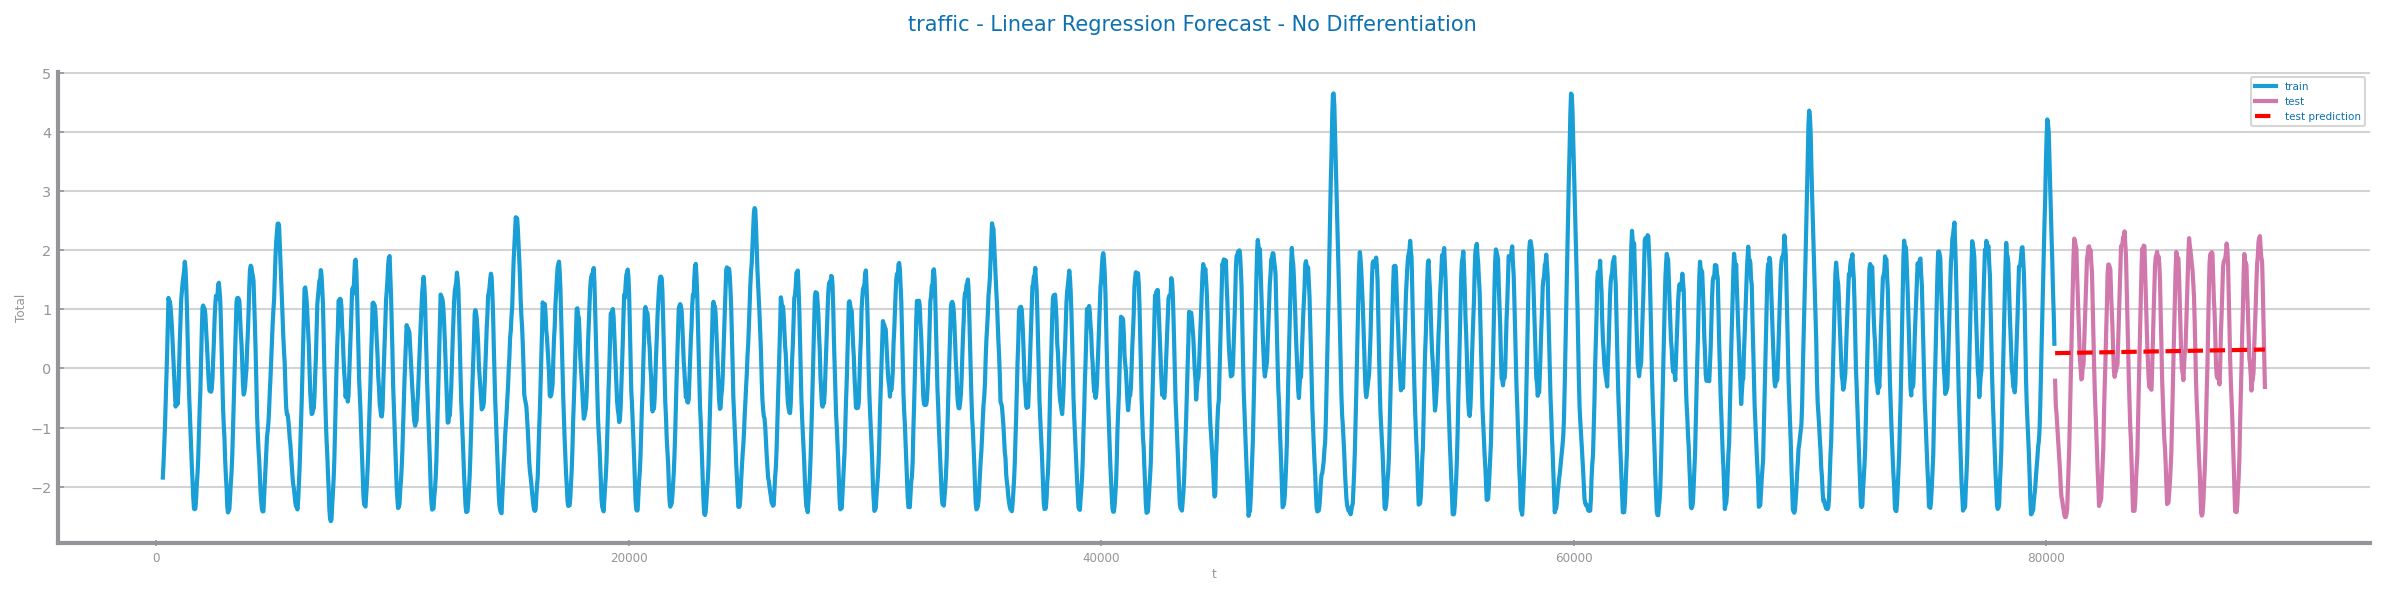

Train: 2669
Test: 297


<Figure size 600x450 with 0 Axes>

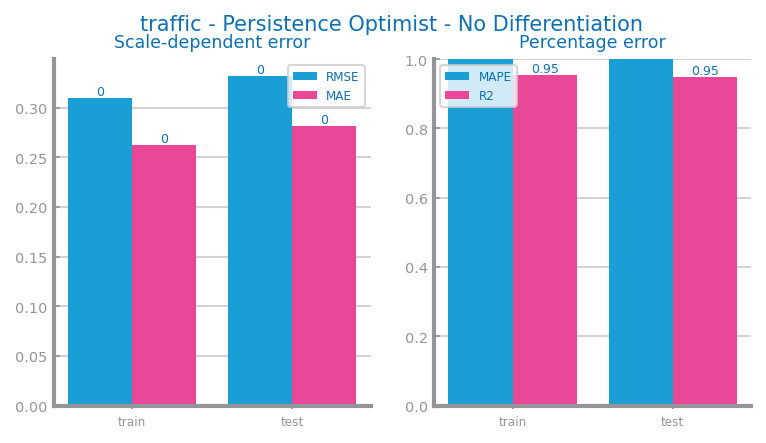

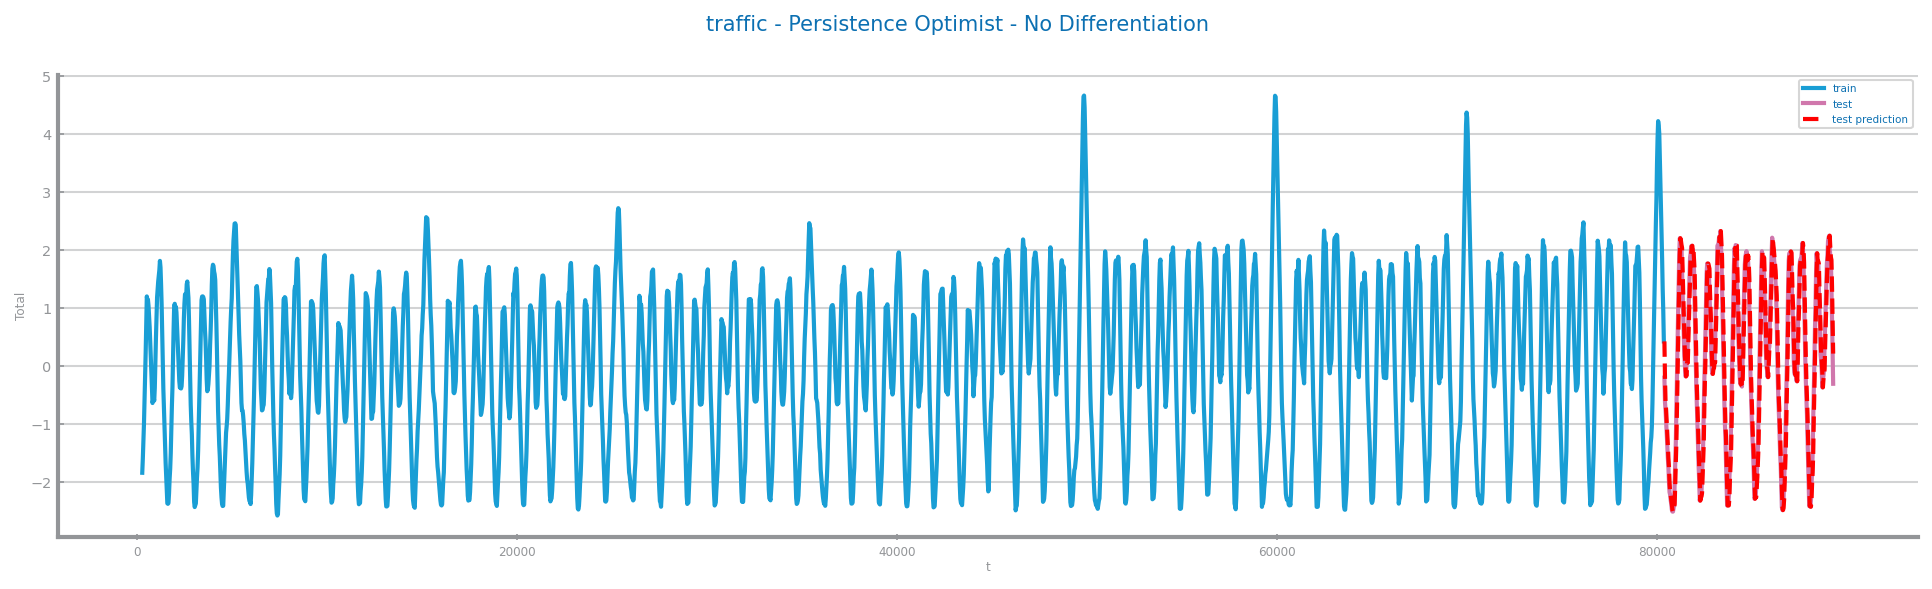

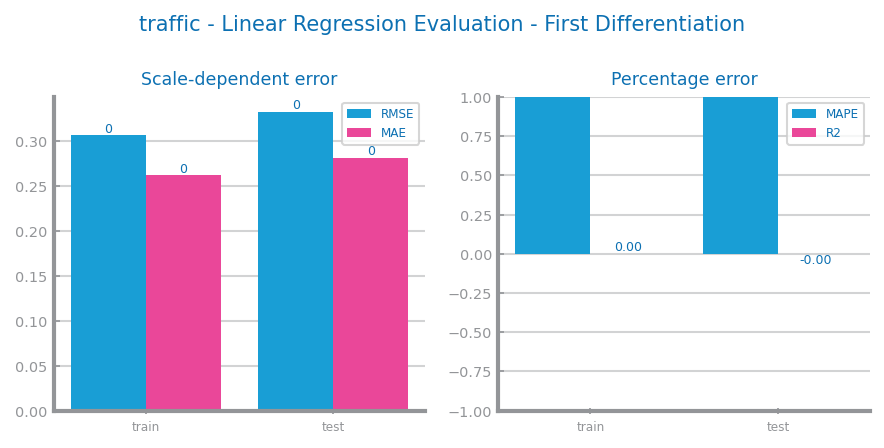

<Figure size 600x450 with 0 Axes>

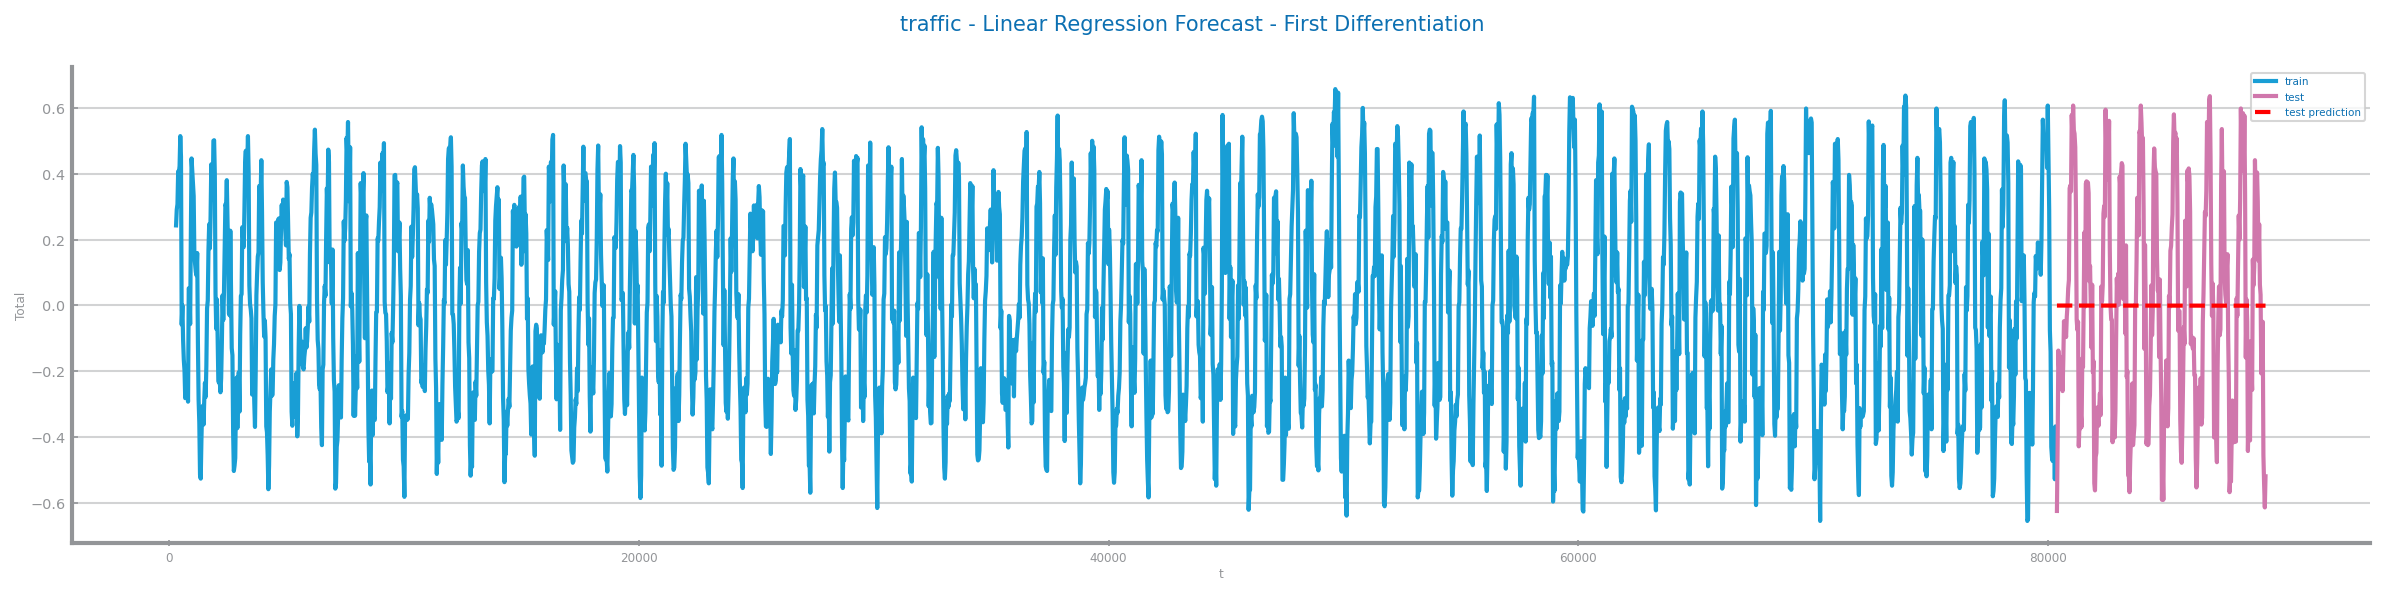

Train: 2668
Test: 297


<Figure size 600x450 with 0 Axes>

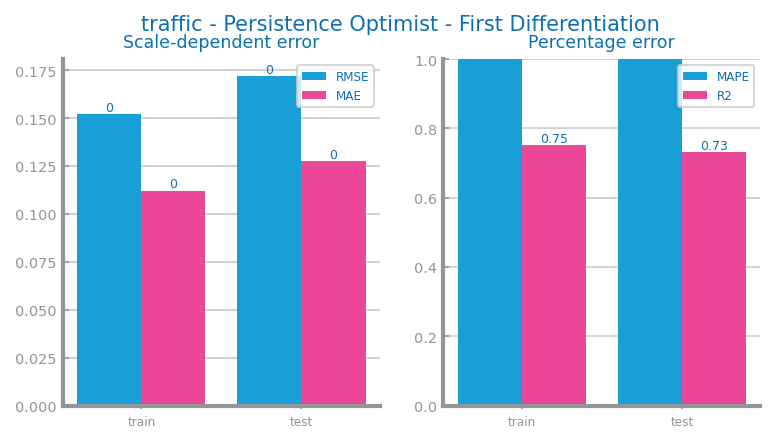

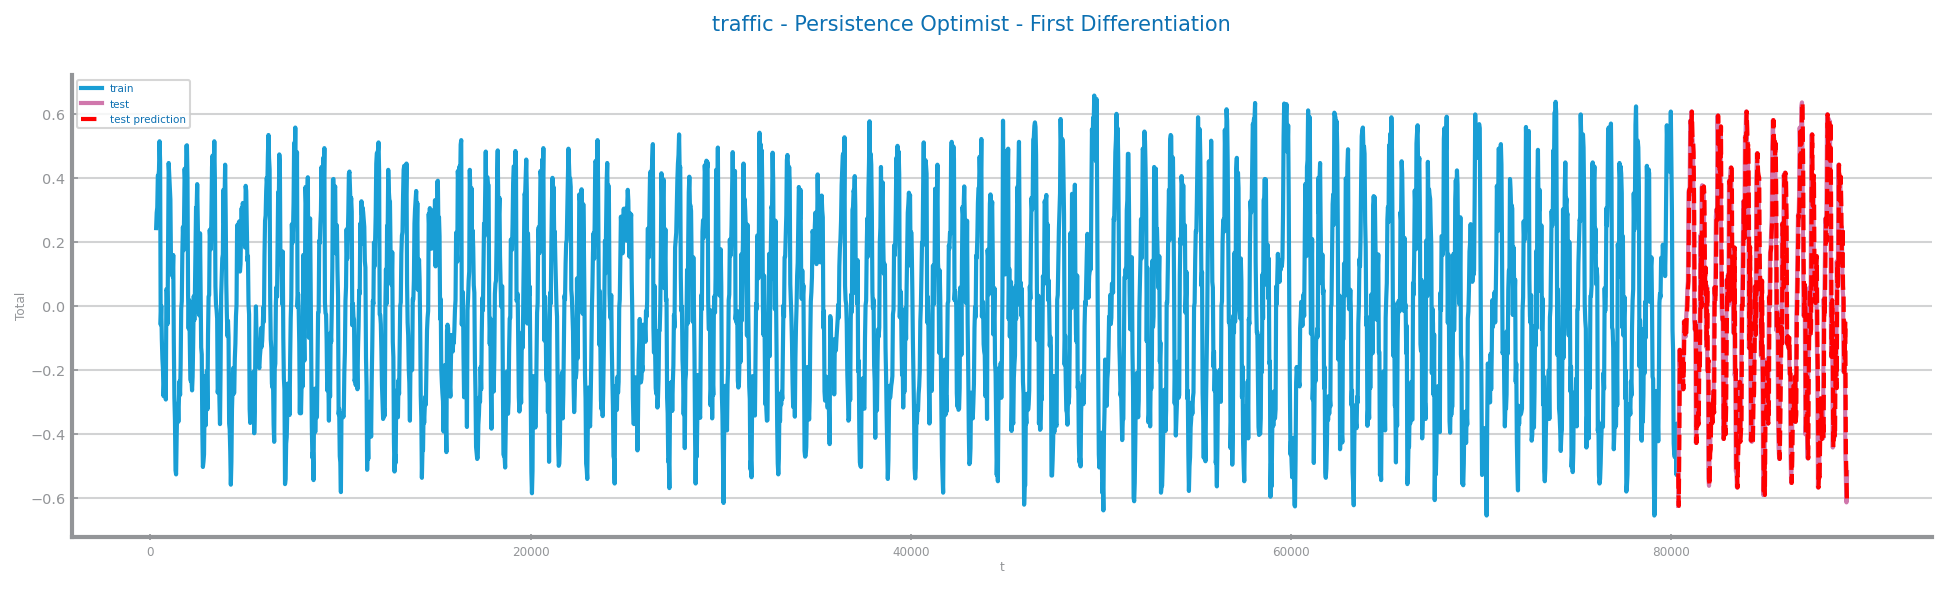

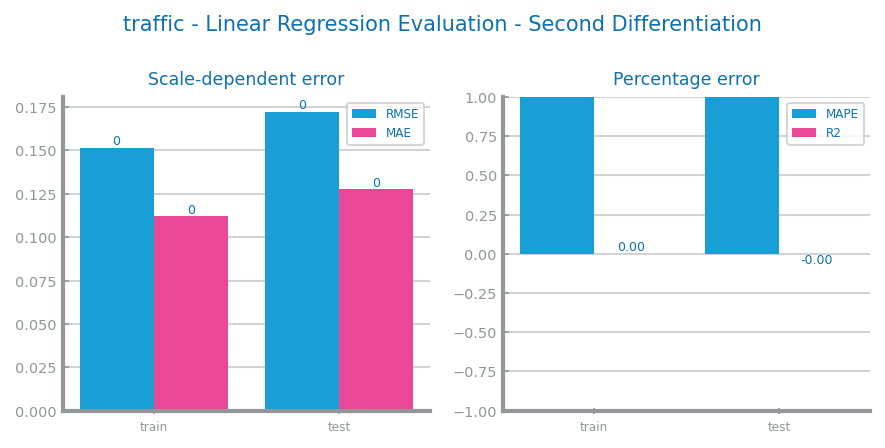

<Figure size 600x450 with 0 Axes>

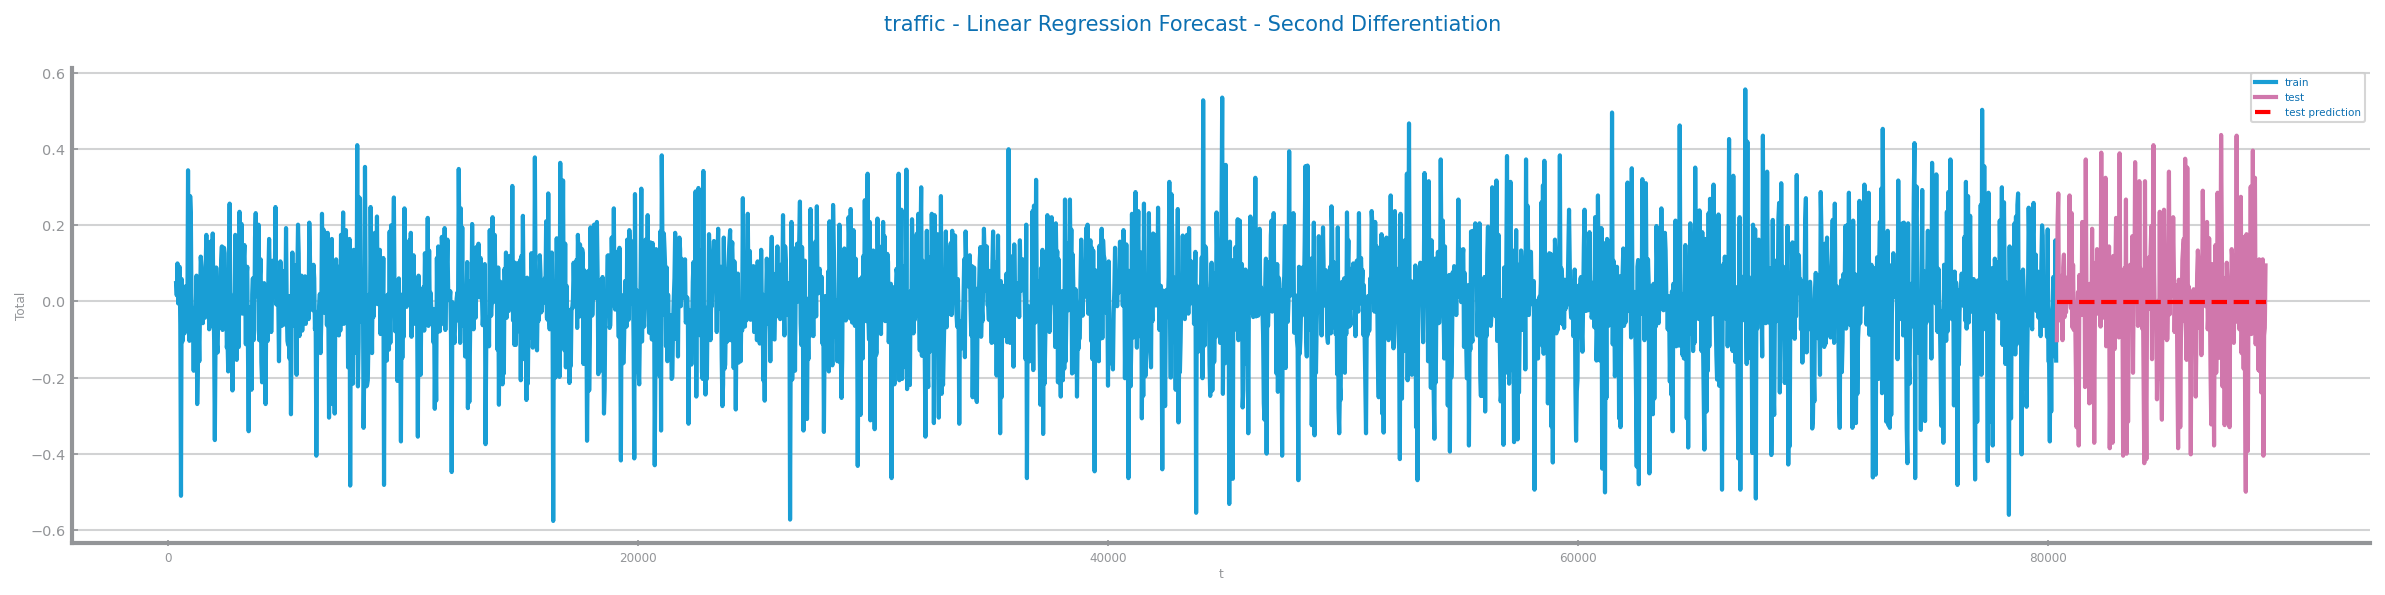

<Figure size 600x450 with 0 Axes>

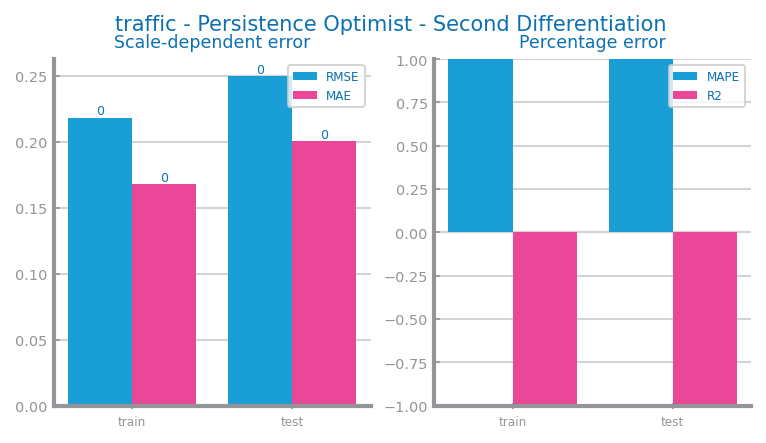

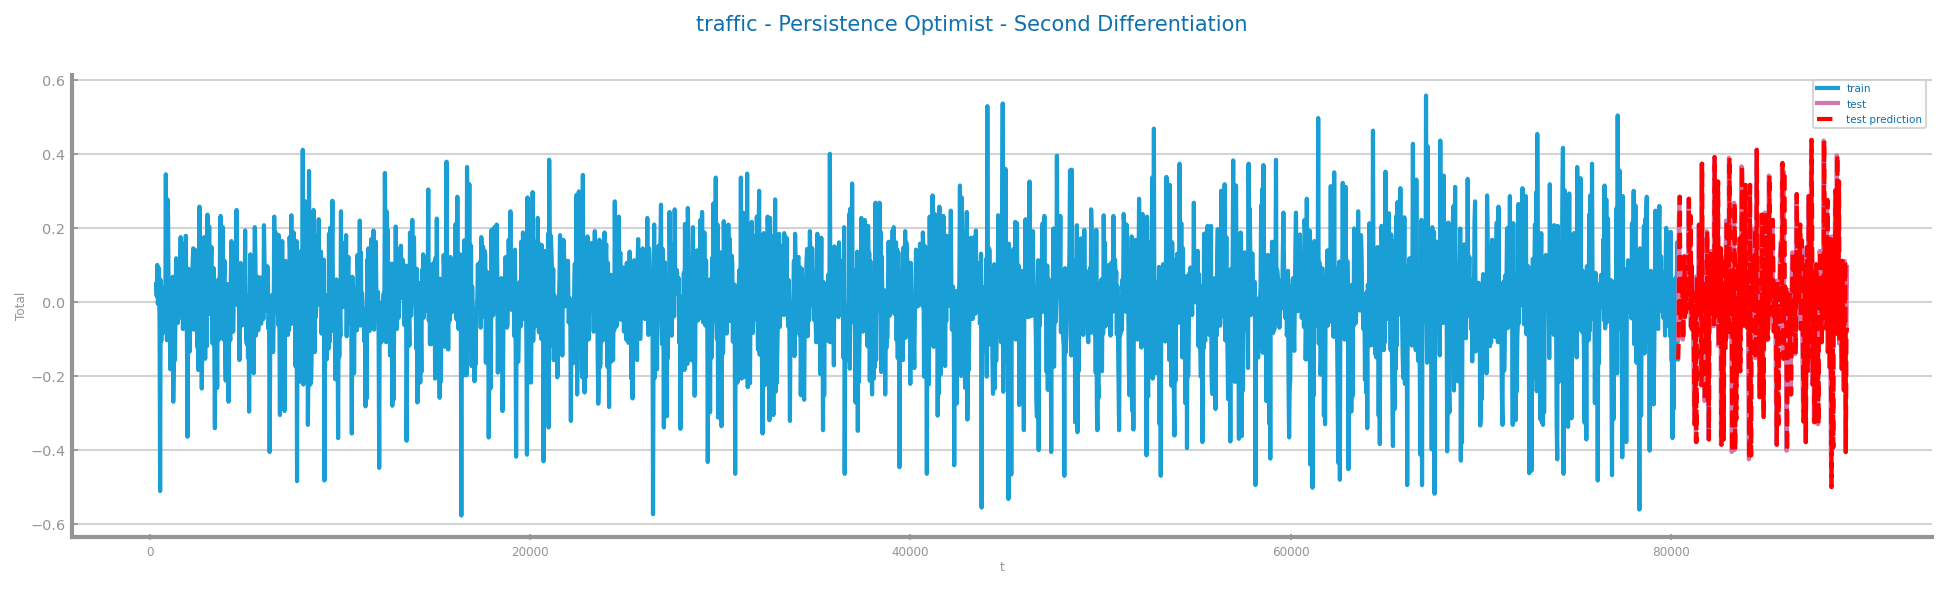

In [25]:
import time

file_tag: str = "traffic"
index_col: str = "t"
target: str = "Total"

run_aggregation_study = False
run_smoothing_study = False
run_differentiation_study = True

"""
------------------
Aggregation
------------------
% Approach 1: Hourly Aggregation
% Approach 3: Daily Aggregation
% Approach 4: Weekly Aggregation
% Approach 4: 30min Aggregation
% Approach 5: 15min Aggregation
"""
if run_aggregation_study:
    run_REG_Persistence_study(
        filename="/content/i/traffic_hourly_aggregated.csv",
        file_tag=file_tag,
        index_col=index_col,
        target=target,
        title="Hourly Aggregation"
    )
    time.sleep(5)
    run_REG_Persistence_study(
        filename="/content/i/traffic_daily_aggregated.csv",
        file_tag=file_tag,
        index_col=index_col,
        target=target,
        title="Daily Aggregation"
    )
    time.sleep(5)
    run_REG_Persistence_study(
        filename="i/traffic_weekly_aggregated.csv",
        file_tag=file_tag,
        index_col=index_col,
        target=target,
        title="Weekly Aggregation", percent = 0.7
    )
    time.sleep(5)
    run_REG_Persistence_study(
        filename="i/traffic_30min_aggregated.csv",
        file_tag=file_tag,
        index_col=index_col,
        target=target,
        title="30min Aggregation"
    )
    time.sleep(5)
    run_REG_Persistence_study(
        filename="/content/traffic_scaled.csv",
        file_tag=file_tag,
        index_col=index_col,
        target=target,
        title="15min Aggregation"
    )

"""
------------------
Smoothing
------------------

% Smoothing Sizes: 3,5,10,15
"""

if run_smoothing_study:
    sizes: list[int] = [3,5,10,15]
    for i in range(len(sizes)):
        run_REG_Persistence_study(
            filename=f"traffic_smoothed_size_{sizes[i]}.csv",
            file_tag=file_tag,
            index_col=index_col,
            target=target,
            title=f"Smoothing Size {sizes[i]}"
        )
        time.sleep(5)

"""
------------------
Differentiation
------------------
% Approach 1: No differentiation
% Approach 2: First differentiation
% Approach 3: Second differentiation
"""
if run_differentiation_study:
    run_REG_Persistence_study(
        filename="traffic_smoothed_size_10.csv",
        file_tag=file_tag,
        index_col=index_col,
        target=target,
        title="No Differentiation"
    )
    time.sleep(5)
    run_REG_Persistence_study(
        filename="traffic_first_diff.csv",
        file_tag=file_tag,
        index_col=index_col,
        target=target,
        title="First Differentiation"
    )
    time.sleep(5)
    run_REG_Persistence_study(
        filename="traffic_second_diff.csv",
        file_tag= file_tag,
        index_col=index_col,
        target=target,
        title="Second Differentiation"
    )
    time.sleep(5)